# Анализ трендов температур по полигонам ЛКЗ (локальных климатических зон)

In [29]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df_orig = pd.read_csv(r"D:\Kursach_2\data_gee\LST_Mean_by_LCZ_ok.csv", sep=',')

# Входные данные: средняя LST по каждому полигону (получено через GEE)

In [31]:
df_orig

# Данные выглядят так

system:index  lcz  lcz_id  lcz_name   mean_BU    mean_LST  \
0      00000000000000000000_0    1      11  moscvich -0.273184  302.137634   
1      00000000000000000000_1    1      11  moscvich -0.272194  304.176099   
2      00000000000000000000_2    1      11  moscvich -0.256523  303.287335   
3      00000000000000000000_3    1      11  moscvich -0.235384  300.912883   
4      00000000000000000000_4    1      11  moscvich -0.254030  313.794346   
...                       ...  ...     ...       ...       ...         ...   
1515  00000000000000000023_33    8      86   severny -0.387575  306.767366   
1516  00000000000000000023_34    8      86   severny -0.327059  311.132157   
1517  00000000000000000023_35    8      86   severny -0.315141  309.422083   
1518  00000000000000000023_36    8      86   severny -0.350552  304.339523   
1519  00000000000000000023_37    8      86   severny -0.338018  314.156480   

      mean_NDBI       rus_name    year                                    .geo  
0     -0.094475  Завод Москвич  1984.0  {"type":"MultiPoint","coordinates":[]}  
1     -0.092253  Завод Москвич  1985.0  {"type":"MultiPoint","coordinates":[]}  
2     -0.092258  Завод Москвич  1986.0  {"type":"MultiPoint","coordinates":[]}  
3     -0.077059  Завод Москвич  1987.0  {"type":"MultiPoint","coordinates":[]}  
4     -0.077408  Завод Москвич  1988.0  {"type":"MultiPoint","coordinates":[]}  
...         ...            ...     ...                                     ...  
1515  -0.147997  ТПЗ Алтуфьево  2020.0  {"type":"MultiPoint","coordinates":[]}  
1516  -0.079645  ТПЗ Алтуфьево  2021.0  {"type":"MultiPoint","coordinates":[]}  
1517  -0.076855  ТПЗ Алтуфьево  2022.0  {"type":"MultiPoint","coordinates":[]}  
1518  -0.091087  ТПЗ Алтуфьево  2023.0  {"type":"MultiPoint","coordinates":[]}  
1519  -0.091853  ТПЗ Алтуфьево  2024.0  {"type":"MultiPoint","coordinates":[]}  

[1520 rows x 10 columns]

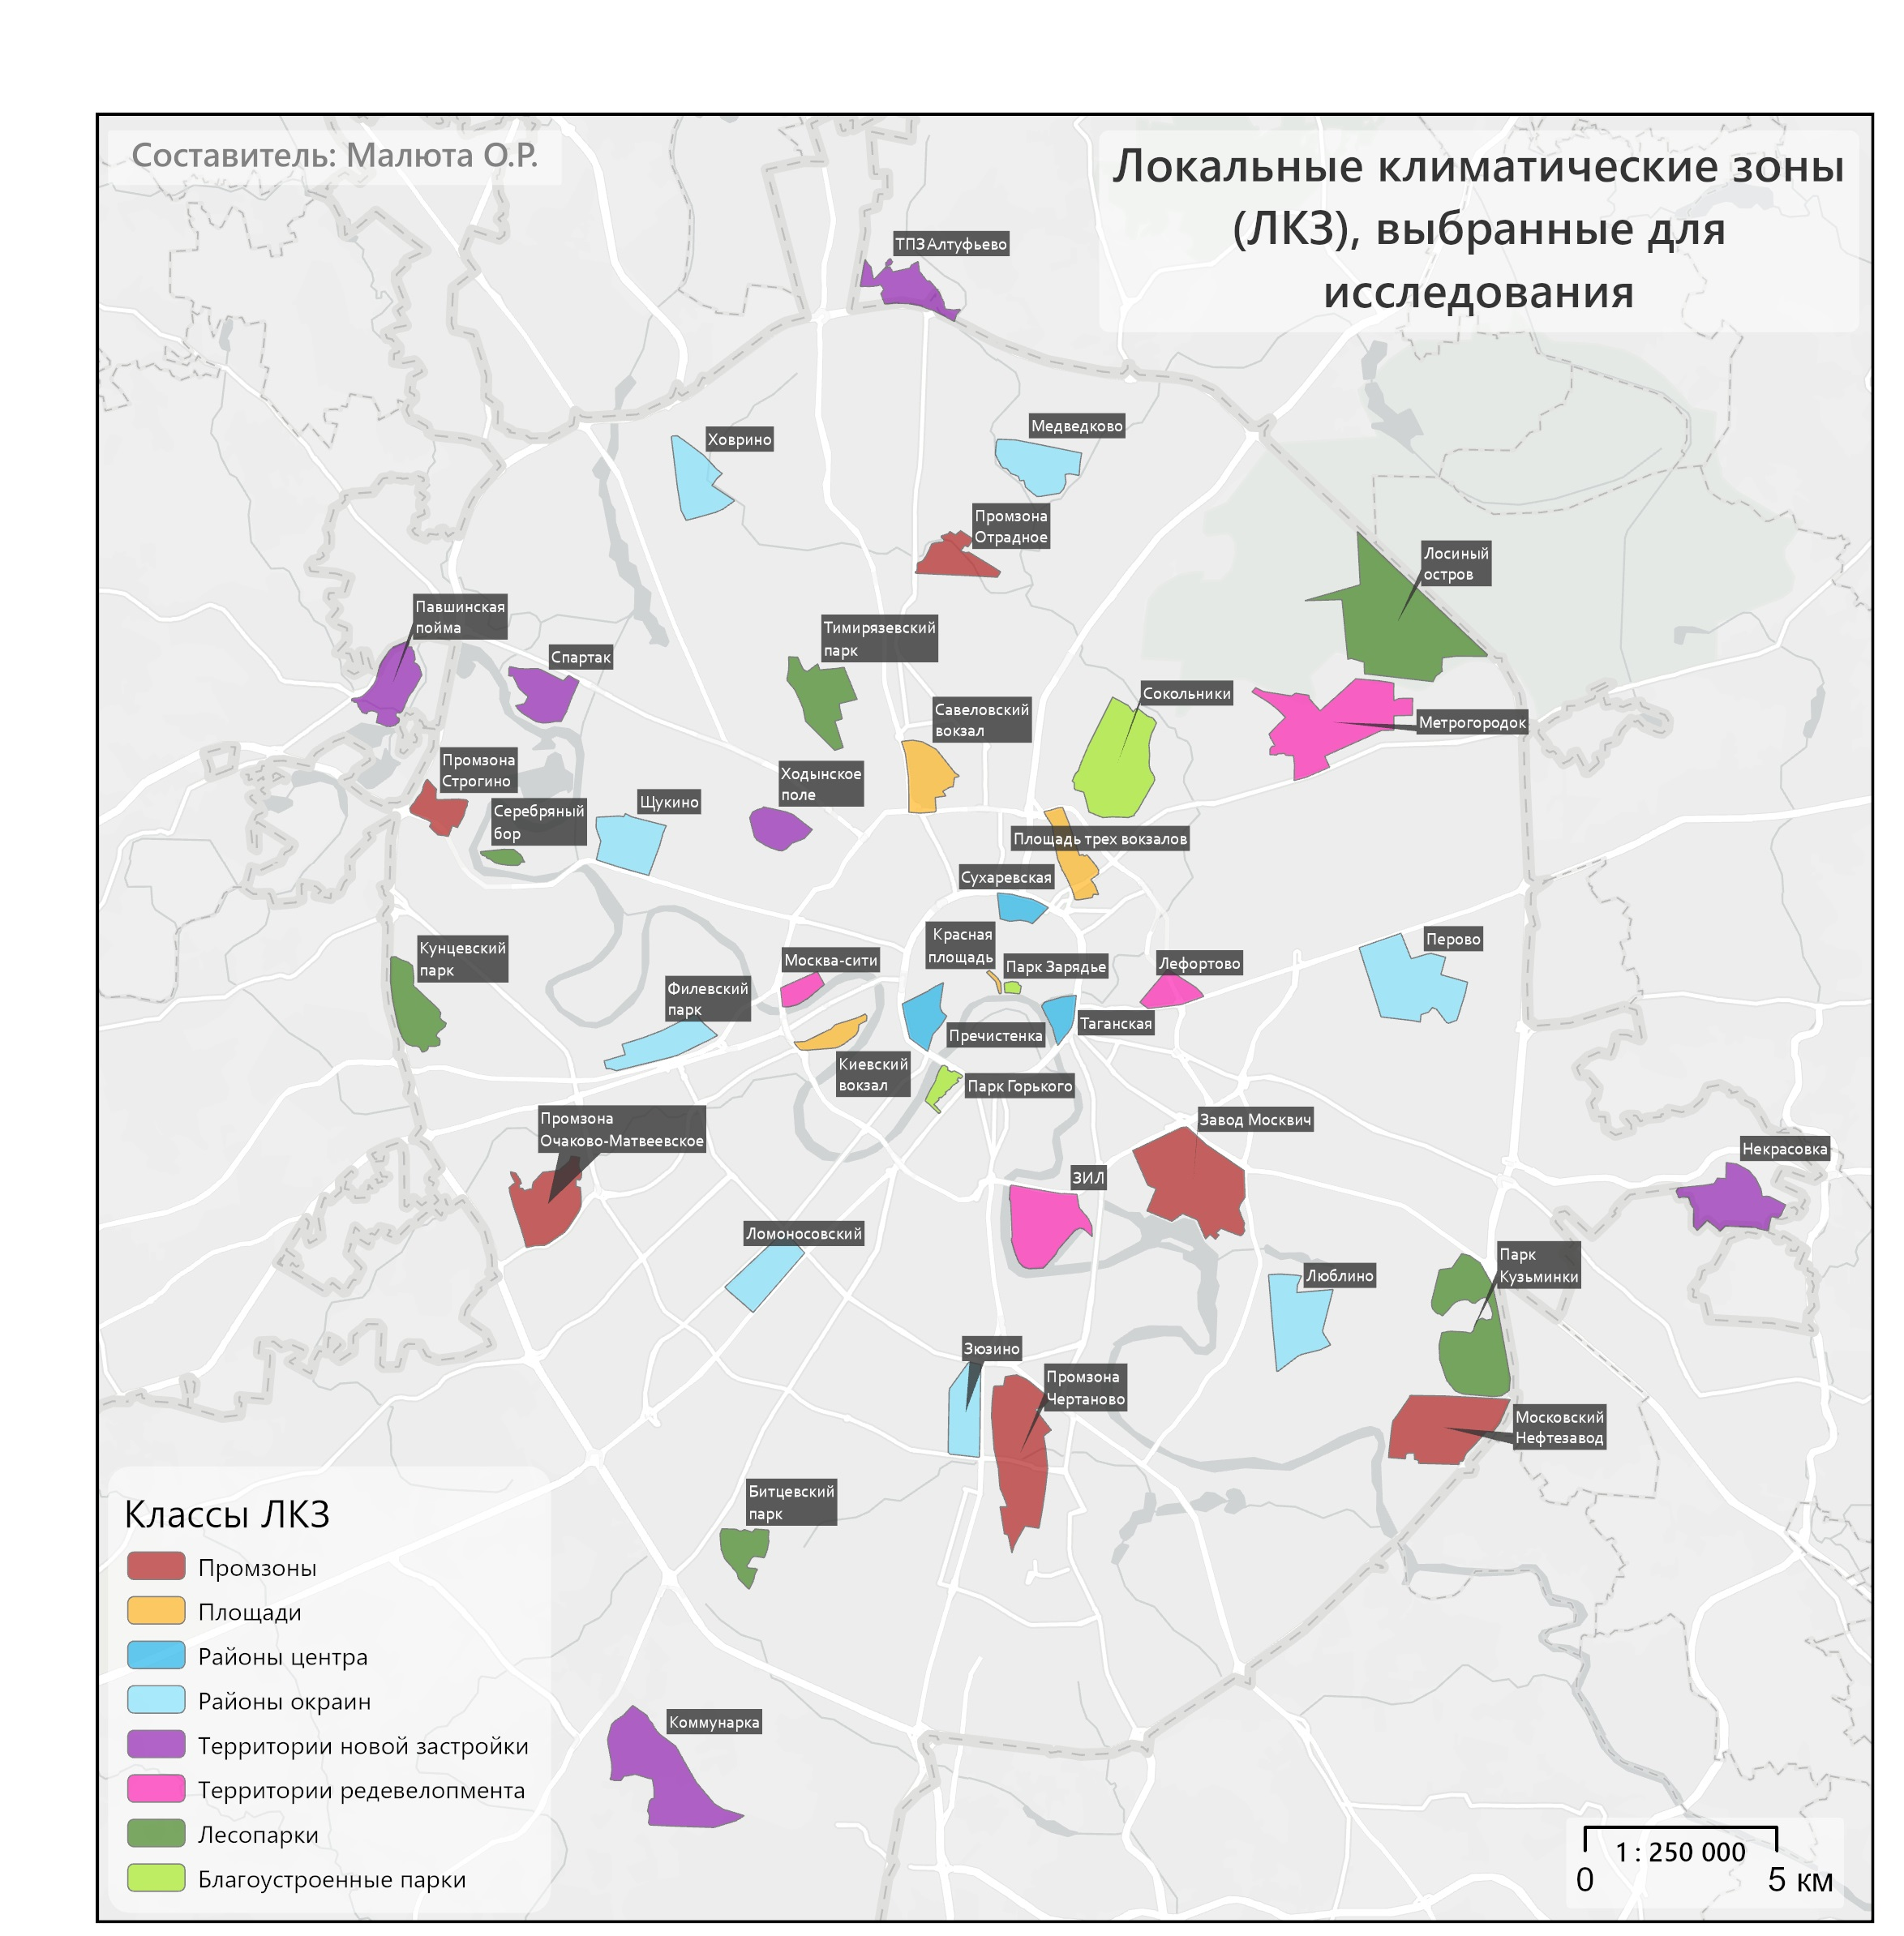

In [32]:
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   system:index  1520 non-null   object 
 1   lcz           1520 non-null   int64  
 2   lcz_id        1520 non-null   int64  
 3   lcz_name      1520 non-null   object 
 4   mean_BU       1489 non-null   float64
 5   mean_LST      1489 non-null   float64
 6   mean_NDBI     1489 non-null   float64
 7   rus_name      1520 non-null   object 
 8   year          1520 non-null   float64
 9   .geo          1520 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 118.9+ KB


In [33]:
df = df_orig.drop(['system:index',  '.geo'], axis=1)

# Удаление бесполезных колонок

In [34]:
df['mean_LST'] = df['mean_LST']-273.15

# Кельвины в Цельсии

In [35]:
classes = {1:'Промзоны', 2:'Площади', 3:'Лесопарки', 4:'Районы центра', 5:'Районы окраин', 
           6:'Благоустроенные парки', 7:'Территории редевелопмента', 8:'Территории новой застройки'}

# Имена классов в соответствии с уникальными типами ЛКЗ

In [36]:
df['classname'] = df['lcz'].apply(lambda classid: classes[classid]) 

# Присвоение именов классов каждому полигону

In [37]:
df.sample(5)

lcz  lcz_id               lcz_name   mean_BU   mean_LST  mean_NDBI  \
721     4      43                taganka -0.391699  36.127776  -0.103763   
980     5      57                 perovo -0.747526  28.452312  -0.272202   
398     3      31          losiny_ostrov -1.004711  17.275370  -0.360293   
1130    6      63               zaryadye -0.227867  27.889233  -0.025294   
94      1      13  ochakovo_matveevskoye -0.390300  26.061990  -0.115415   

                          rus_name    year              classname  
721                      Таганская  2024.0          Районы центра  
980                         Перово  2017.0          Районы окраин  
398                 Лосиный Остров  2004.0              Лесопарки  
1130                  Парк Зарядье  2015.0  Благоустроенные парки  
94    Промзона Очаково-Матвеевское  2004.0               Промзоны

In [38]:
df['year'] = df['year'].astype(int) 

# Годы - целые числа

In [39]:
polygons_id = df['lcz_id'].unique()
polygons_id

# Уникальные номера полигонов ЛКЗ

array([11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 31, 32, 33, 34, 35, 36, 41,
       42, 43, 51, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 71, 72, 73, 74,
       81, 82, 83, 84, 85, 86], dtype=int64)

In [40]:
classes = df['lcz'].unique()
classes 

# Уникальные номера классов

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [41]:
df['mean_LST'].isna().sum()/len(df)*100 

# Процент NaN

2.0394736842105265

In [42]:
df.corr(numeric_only=True)[['mean_LST', 'mean_BU']].loc['mean_LST']

# Корреляция Пирсона между LST (температурой) и BU (индексом застройки) = 0.68!

mean_LST    1.000000
mean_BU     0.682457
Name: mean_LST, dtype: float64

# Смотрим наличие линейного тренда по исходным данным

Визуализация и построение линии тренда

In [43]:
df_clean = df.dropna(subset=['mean_LST'])

# Удаляем пустые данные

In [44]:
df_clean = df_clean.reset_index()
df_clean = df_clean.set_index('lcz_id')

# Смотрим по полигонам

In [45]:
df_clean

index  lcz  lcz_name   mean_BU   mean_LST  mean_NDBI       rus_name  \
lcz_id                                                                        
11          0    1  moscvich -0.273184  28.987634  -0.094475  Завод Москвич   
11          1    1  moscvich -0.272194  31.026099  -0.092253  Завод Москвич   
11          2    1  moscvich -0.256523  30.137335  -0.092258  Завод Москвич   
11          3    1  moscvich -0.235384  27.762883  -0.077059  Завод Москвич   
11          4    1  moscvich -0.254030  40.644346  -0.077408  Завод Москвич   
...       ...  ...       ...       ...        ...        ...            ...   
86       1515    8   severny -0.387575  33.617366  -0.147997  ТПЗ Алтуфьево   
86       1516    8   severny -0.327059  37.982157  -0.079645  ТПЗ Алтуфьево   
86       1517    8   severny -0.315141  36.272083  -0.076855  ТПЗ Алтуфьево   
86       1518    8   severny -0.350552  31.189523  -0.091087  ТПЗ Алтуфьево   
86       1519    8   severny -0.338018  41.006480  -0.091853  ТПЗ Алтуфьево   

        year                   classname  
lcz_id                                    
11      1984                    Промзоны  
11      1985                    Промзоны  
11      1986                    Промзоны  
11      1987                    Промзоны  
11      1988                    Промзоны  
...      ...                         ...  
86      2020  Территории новой застройки  
86      2021  Территории новой застройки  
86      2022  Территории новой застройки  
86      2023  Территории новой застройки  
86      2024  Территории новой застройки  

[1489 rows x 9 columns]

Графики трендов

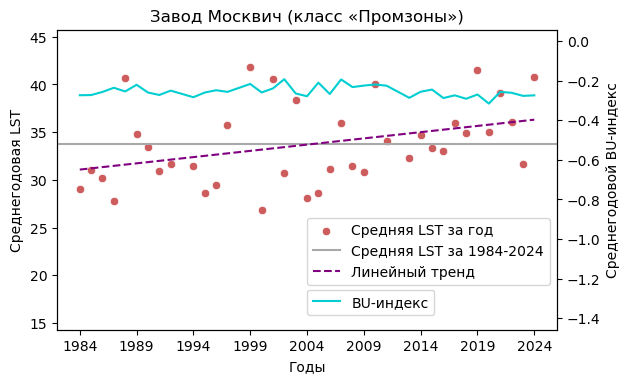

In [46]:
# Визуализация одного примера

ts_poly_df_clean = df_clean.loc[11]

x = ts_poly_df_clean['year']
years_ticks = np.arange(x.min(), x.max()+1, 5)

y = ts_poly_df_clean['mean_LST']
ymin = df_clean['mean_LST'].min() - 1
ymax = df_clean['mean_LST'].max() + 2

y2 = ts_poly_df_clean['mean_BU']
y2min = df_clean['mean_BU'].min() - 0.2
y2max = df_clean['mean_BU'].max() + 0.1 

fig = plt.figure(figsize=(5,3), dpi=100)
ax1 = fig.add_axes([0,0,1,1])
ax1.set_ylim(ymin, ymax)

sns.scatterplot(x=x, y=y, ax=ax1, color='indianred')
ax1.axhline(y.mean(), color='darkgrey')

coeffs = np.polyfit(x, y, 1)
polynomial = np.poly1d(coeffs)
ax1.plot(x, polynomial(x), color='purple', ls='--')
ax1.set_xlabel('Годы')
ax1.set_xticks(years_ticks)
ax1.set_ylabel('Среднегодовая LST')
plt.legend(['Средняя LST за год','Средняя LST за 1984-2024','Линейный тренд'], loc=[0.5,0.15])

ax2 = ax1.twinx()
ax2.set_ylim(y2min,y2max)
ax2.set_ylabel('Среднегодовой BU-индекс')
sns.lineplot(x=x, y=y2, ax=ax2, color='darkturquoise')
plt.legend(['BU-индекс'], loc=[0.5,0.05])

title = plt.title(f'{ts_poly_df_clean["rus_name"].iloc[0]} (класс «{ts_poly_df_clean["classname"].iloc[0]}»)')
# plt.tight_layout()
# plt.savefig(f'D:\Kursach_2\comps\plots\{title}.png', bbox_inches='tight')
plt.show()

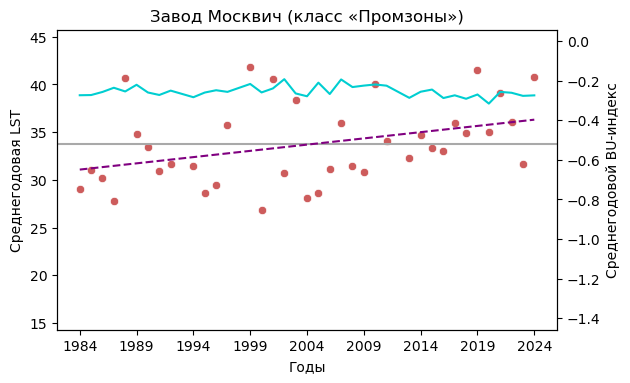

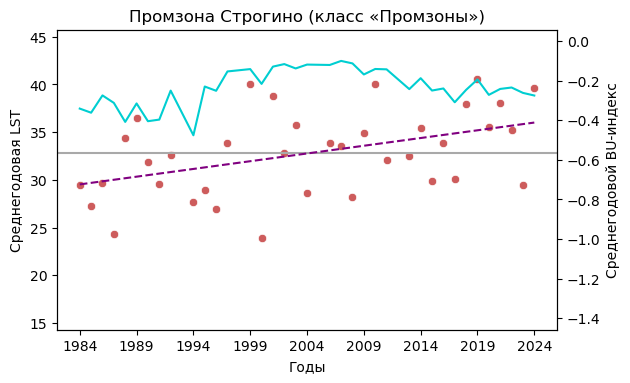

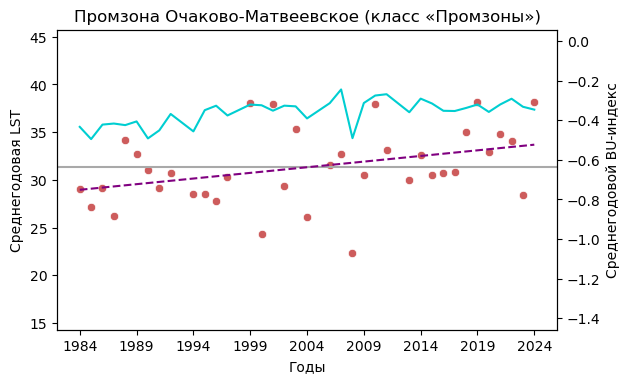

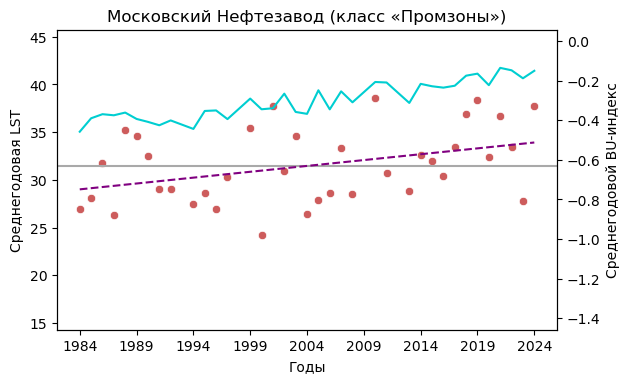

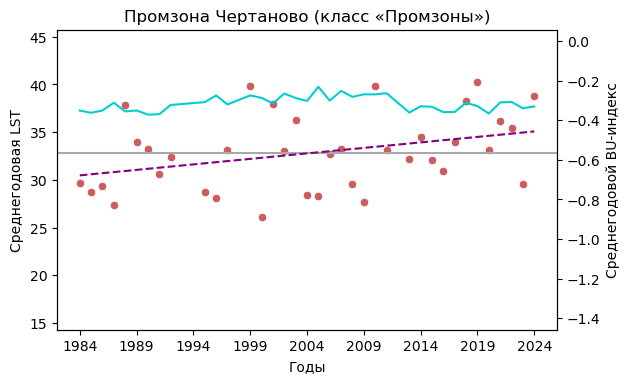

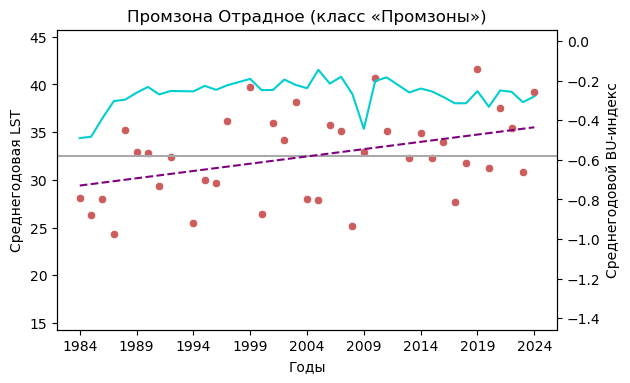

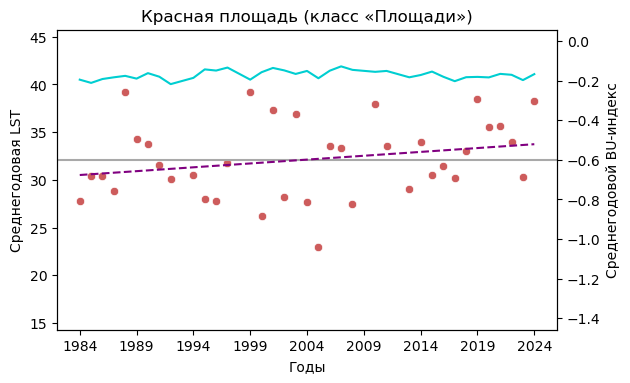

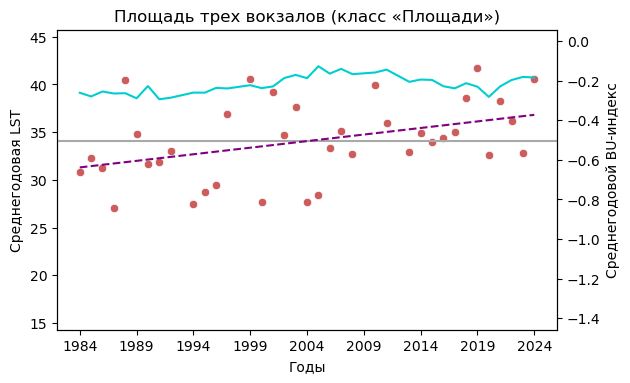

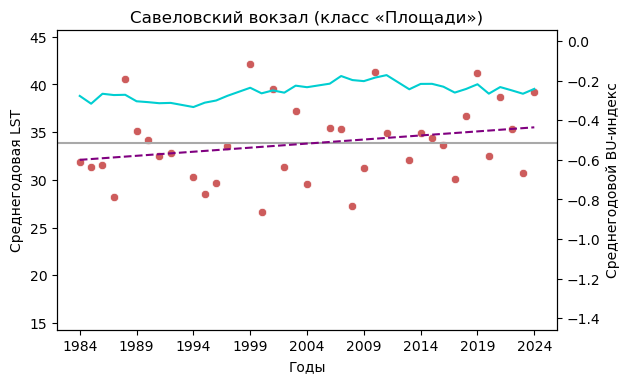

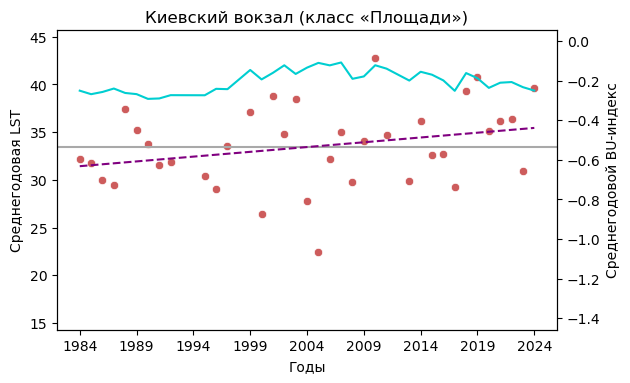

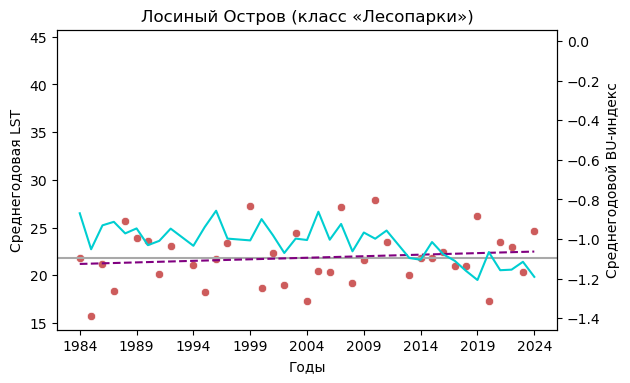

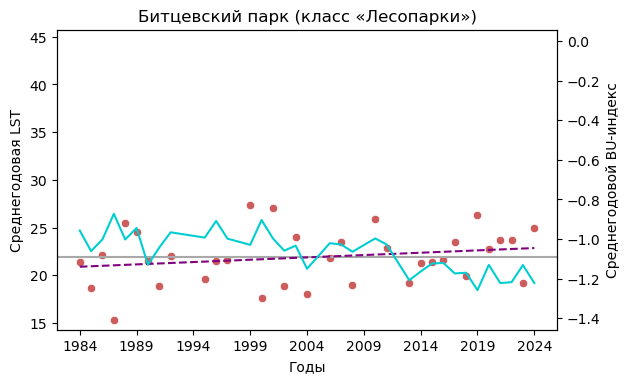

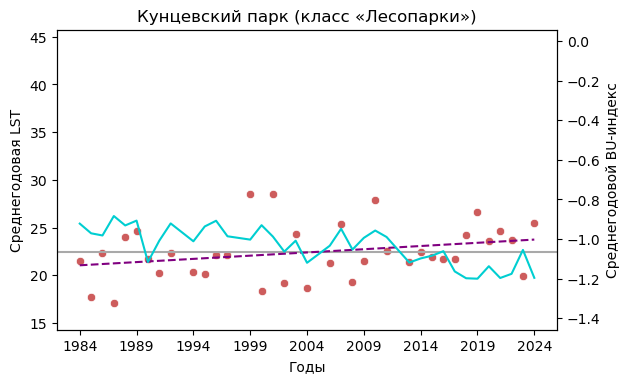

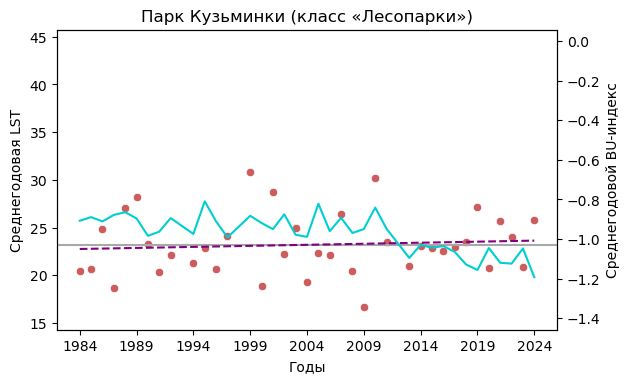

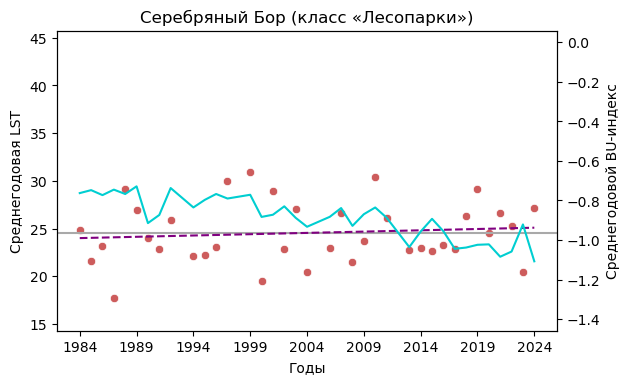

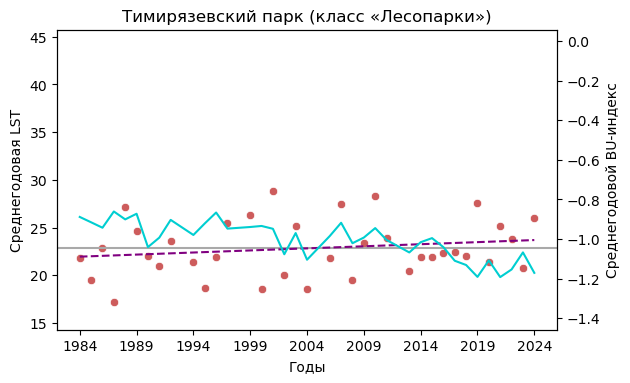

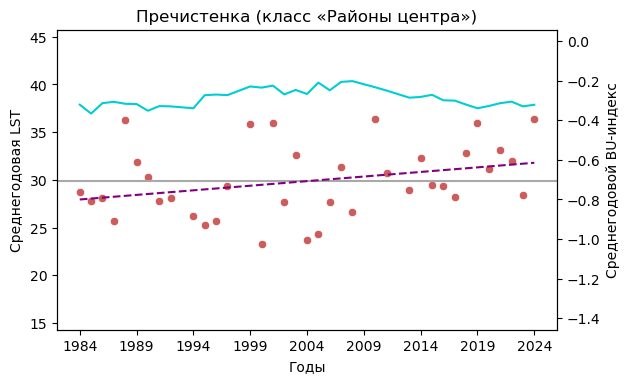

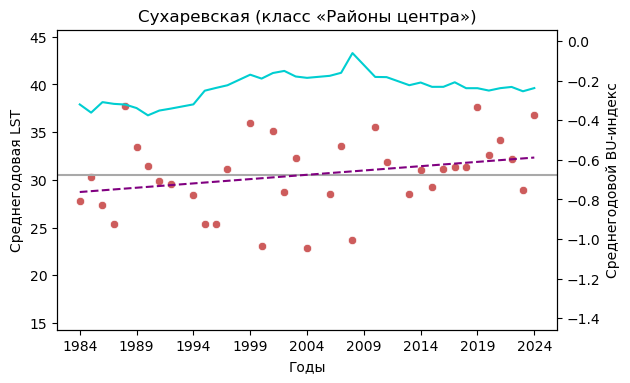

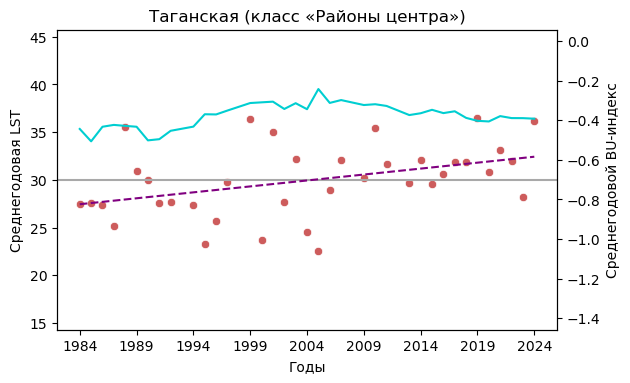

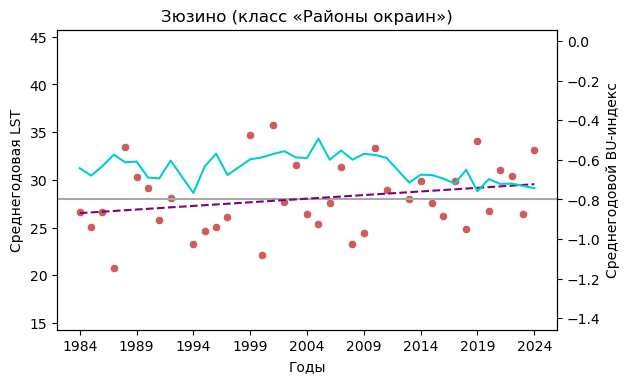

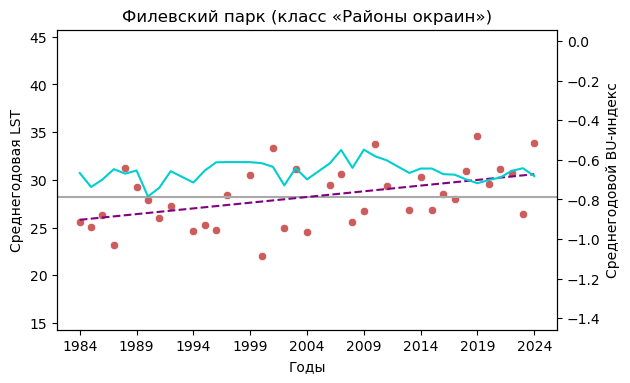

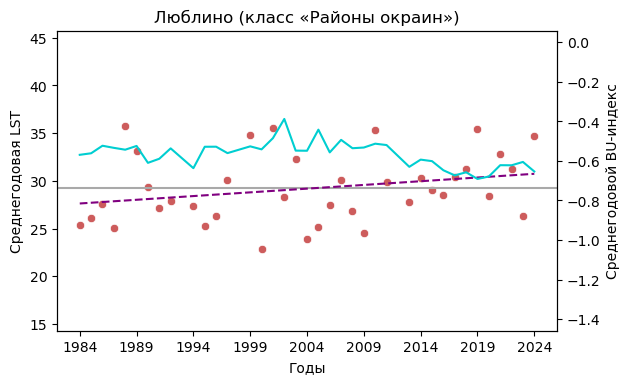

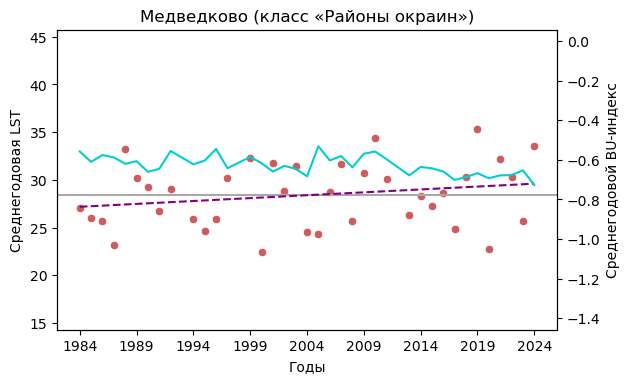

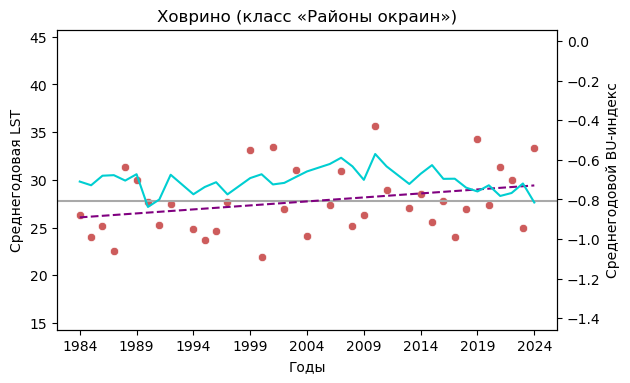

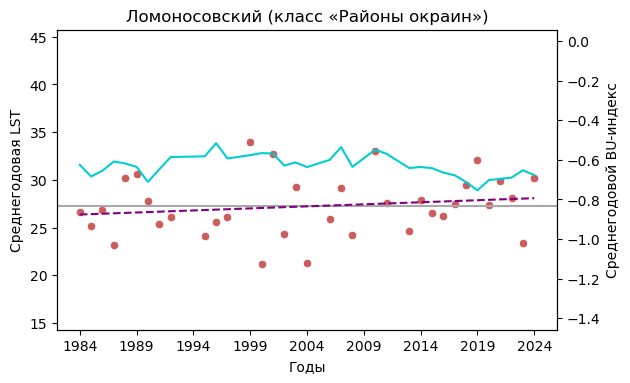

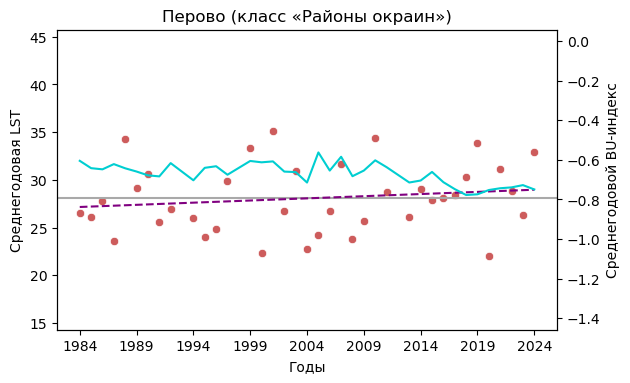

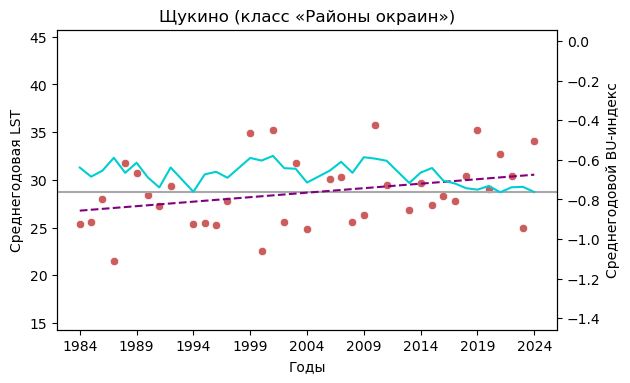

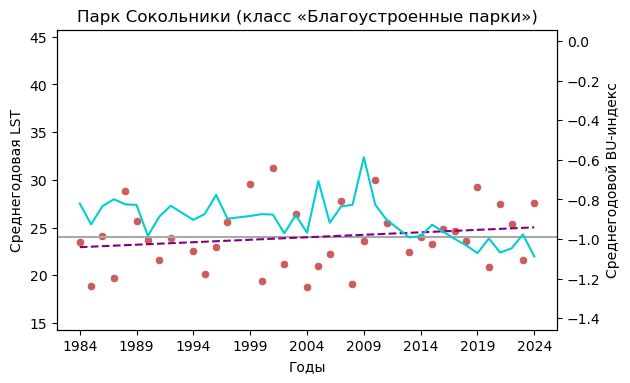

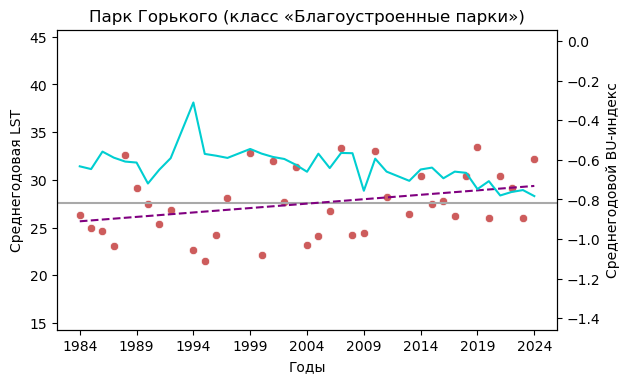

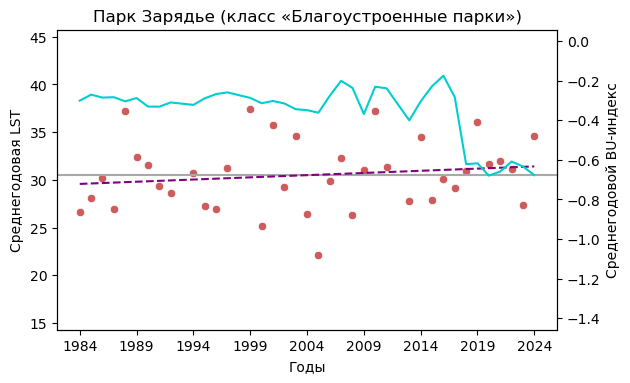

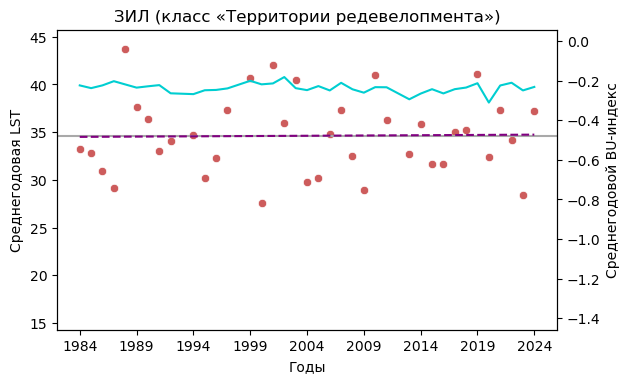

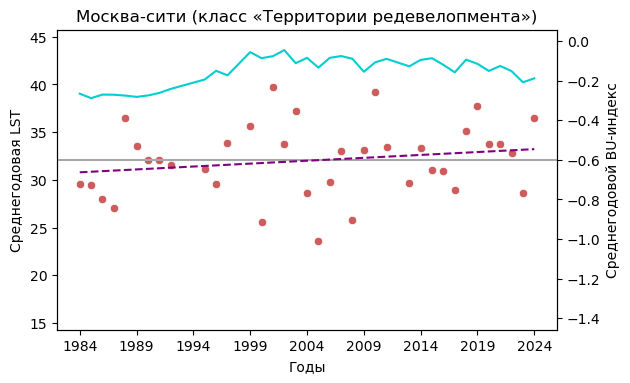

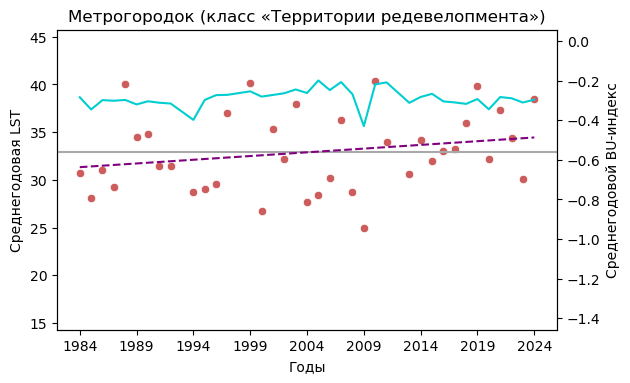

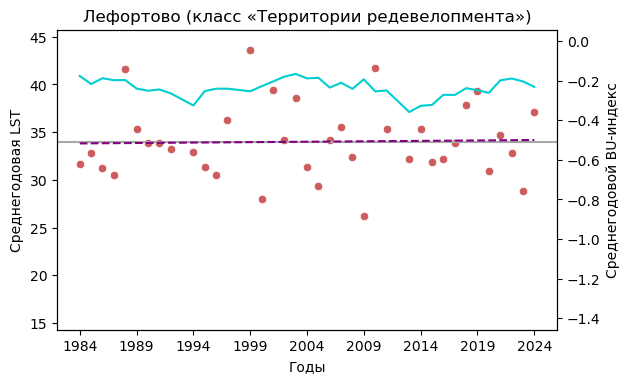

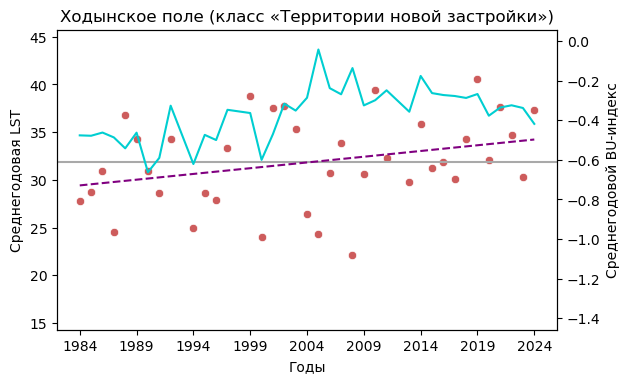

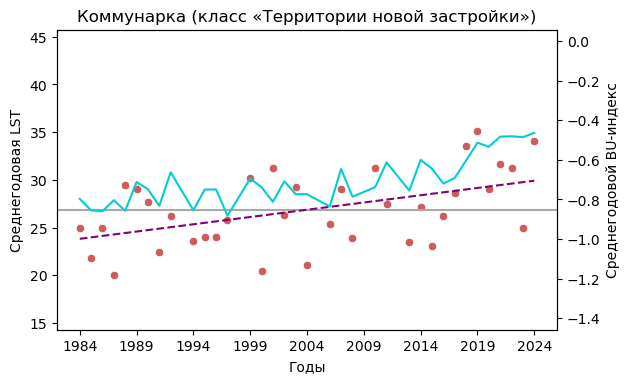

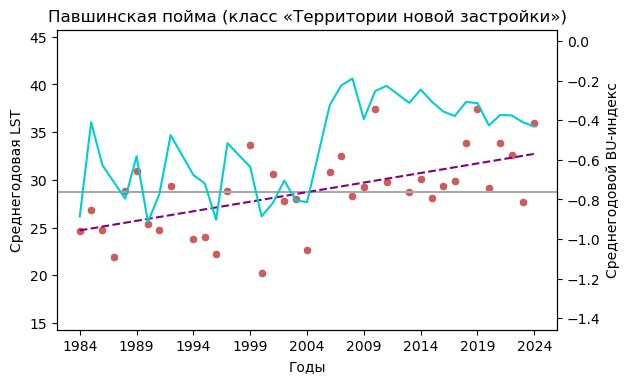

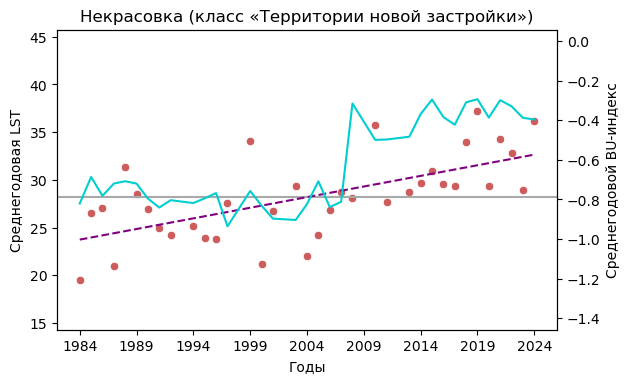

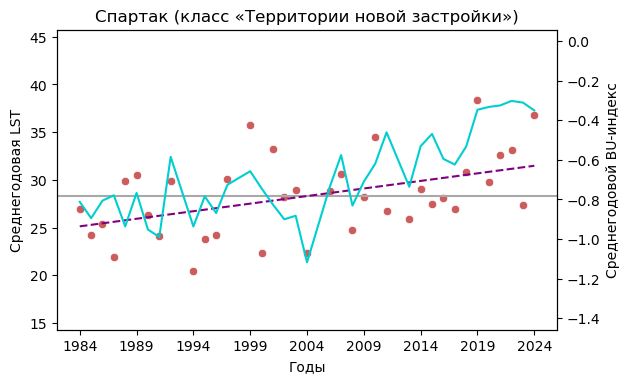

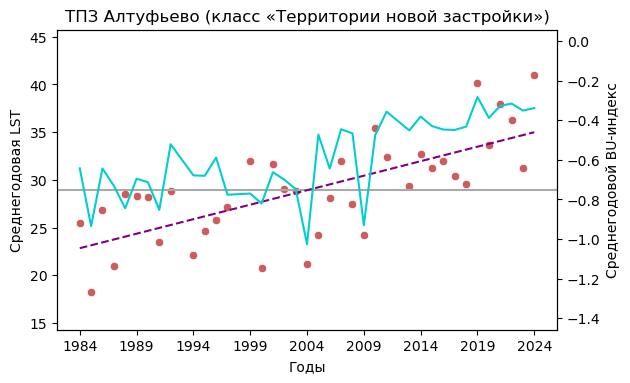

In [47]:
for ID in polygons_id:
    
    ts_poly_df_clean = df_clean.loc[ID]
    
    x = ts_poly_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)
    
    y = ts_poly_df_clean['mean_LST']
    ymin = df_clean['mean_LST'].min() - 1
    ymax = df_clean['mean_LST'].max() + 2
    
    y2 = ts_poly_df_clean['mean_BU']
    y2min = df_clean['mean_BU'].min() - 0.2
    y2max = df_clean['mean_BU'].max() + 0.1 
    
    fig = plt.figure(figsize=(5,3))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_ylim(ymin, ymax)
    
    sns.scatterplot(x=x, y=y, ax=ax1, color='indianred')
    ax1.axhline(y.mean(), color='darkgrey')

    coeffs = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coeffs)
    ax1.plot(x, polynomial(x), color='purple', ls='--')
    ax1.set_xlabel('Годы')
    ax1.set_xticks(years_ticks)
    ax1.set_ylabel('Среднегодовая LST')
    #plt.legend(['LST','Средняя LST','Линейный тренд'], loc=[0.62,0.15])
    
    ax2 = ax1.twinx()
    ax2.set_ylim(y2min,y2max)
    ax2.set_ylabel('Среднегодовой BU-индекс')
    sns.lineplot(x=x, y=y2, ax=ax2, color='darkturquoise')
    #plt.legend(['BU'], loc=[0.62,0.05])

    title = plt.title(f'{ts_poly_df_clean["rus_name"].iloc[0]} (класс «{ts_poly_df_clean["classname"].iloc[0]}»)')
   # plt.tight_layout()
   # plt.savefig(f'D:\Kursach_2\comps\plots\{title}.png', bbox_inches='tight')
    plt.show()

Статистическая проверка значимости тренда

In [48]:
df_clean

index  lcz  lcz_name   mean_BU   mean_LST  mean_NDBI       rus_name  \
lcz_id                                                                        
11          0    1  moscvich -0.273184  28.987634  -0.094475  Завод Москвич   
11          1    1  moscvich -0.272194  31.026099  -0.092253  Завод Москвич   
11          2    1  moscvich -0.256523  30.137335  -0.092258  Завод Москвич   
11          3    1  moscvich -0.235384  27.762883  -0.077059  Завод Москвич   
11          4    1  moscvich -0.254030  40.644346  -0.077408  Завод Москвич   
...       ...  ...       ...       ...        ...        ...            ...   
86       1515    8   severny -0.387575  33.617366  -0.147997  ТПЗ Алтуфьево   
86       1516    8   severny -0.327059  37.982157  -0.079645  ТПЗ Алтуфьево   
86       1517    8   severny -0.315141  36.272083  -0.076855  ТПЗ Алтуфьево   
86       1518    8   severny -0.350552  31.189523  -0.091087  ТПЗ Алтуфьево   
86       1519    8   severny -0.338018  41.006480  -0.091853  ТПЗ Алтуфьево   

        year                   classname  
lcz_id                                    
11      1984                    Промзоны  
11      1985                    Промзоны  
11      1986                    Промзоны  
11      1987                    Промзоны  
11      1988                    Промзоны  
...      ...                         ...  
86      2020  Территории новой застройки  
86      2021  Территории новой застройки  
86      2022  Территории новой застройки  
86      2023  Территории новой застройки  
86      2024  Территории новой застройки  

[1489 rows x 9 columns]

In [49]:
results = [] 

for poly_id in polygons_id:
    
    # Фильтруем по конкретному полигону
    ts_poly = df_clean.loc[poly_id]

    x = ts_poly['year'].values
    y = ts_poly['mean_LST'].values
    
    # Линейная регрессия
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    
    # Сохраняем результат
    results.append({
        'class': ts_poly['lcz'].iloc[0],
        'lcz_id': poly_id,
        'lcz_name': ts_poly['rus_name'].iloc[0],  # берём первую строку как название
        'n_points': len(ts_poly),
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'p_value': p_value,
        'std_err': std_err
    })

# Превращаем в DataFrame
results_df = pd.DataFrame(results)

In [50]:
results_df

class  lcz_id                      lcz_name  n_points     slope  \
0       1      11                 Завод Москвич        38  0.130765   
1       1      12             Промзона Строгино        37  0.162024   
2       1      13  Промзона Очаково-Матвеевское        37  0.118237   
3       1      14         Московский Нефтезавод        37  0.122761   
4       1      15            Промзона Чертаново        37  0.115194   
5       1      16             Промзона Отрадное        38  0.152717   
6       2      21               Красная площадь        37  0.080689   
7       2      22         Площадь трех вокзалов        37  0.137777   
8       2      23            Савеловский вокзал        37  0.085237   
9       2      24               Киевский вокзал        37  0.100271   
10      3      31                Лосиный Остров        38  0.032433   
11      3      32               Битцевский парк        35  0.048910   
12      3      33               Кунцевский парк        37  0.067380   
13      3      34                Парк Кузьминки        38  0.021938   
14      3      35                Серебряный Бор        37  0.027254   
15      3      36            Тимирязевский парк        37  0.043503   
16      4      41                   Пречистенка        37  0.096228   
17      4      42                   Сухаревская        36  0.090310   
18      4      43                     Таганская        37  0.124449   
19      5      51                        Зюзино        38  0.075756   
20      5      52                Филевский парк        37  0.119509   
21      5      53                       Люблино        38  0.077787   
22      5      54                    Медведково        38  0.060555   
23      5      55                       Ховрино        37  0.083722   
24      5      56                 Ломоносовский        35  0.042830   
25      5      57                        Перово        38  0.045228   
26      5      58                        Щукино        37  0.094206   
27      6      61               Парк Сокольники        38  0.051869   
28      6      62                 Парк Горького        38  0.092662   
29      6      63                  Парк Зарядье        38  0.045837   
30      7      71                           ЗИЛ        38  0.005899   
31      7      72                   Москва-сити        37  0.060716   
32      7      73                  Метрогородок        38  0.077804   
33      7      74                     Лефортово        38  0.008949   
34      8      81                Ходынское поле        38  0.120236   
35      8      82                    Коммунарка        36  0.152229   
36      8      83              Павшинская пойма        37  0.200457   
37      8      84                    Некрасовка        36  0.222683   
38      8      85                       Спартак        37  0.158696   
39      8      86                 ТПЗ Алтуфьево        38  0.303915   

     intercept   r_value       p_value   std_err  
0  -228.365502  0.375792  2.006672e-02  0.053744  
1  -291.936446  0.451539  5.027605e-03  0.054117  
2  -205.631368  0.370808  2.386184e-02  0.050055  
3  -214.558833  0.390669  1.681825e-02  0.048894  
4  -198.080149  0.358904  2.914978e-02  0.050638  
5  -273.592570  0.411191  1.032830e-02  0.056425  
6  -129.584444  0.247991  1.388938e-01  0.053280  
7  -242.051247  0.413057  1.105716e-02  0.051347  
8  -137.018483  0.257951  1.232152e-01  0.053964  
9  -167.510994  0.288416  8.342397e-02  0.056268  
10  -43.166169  0.137782  4.094184e-01  0.038858  
11  -76.148225  0.214964  2.149330e-01  0.038682  
12 -112.641972  0.292617  7.882809e-02  0.037218  
13  -20.775689  0.083301  6.190367e-01  0.043740  
14  -30.077454  0.106362  5.309526e-01  0.043067  
15  -64.366062  0.182548  2.795167e-01  0.039605  
16 -162.979797  0.317494  5.551441e-02  0.048580  
17 -150.456509  0.287365  8.924456e-02  0.051624  
18 -219.465923  0.411370  1.142314e-02  0.046609  
19 -123.792897  0.253782  1.241826e-01  0.048123  
20 -211.298563  0.471

In [51]:
nonvalid_poly = results_df[results_df['p_value']>0.05]

In [52]:
nonvalid_poly.groupby('class').count()['p_value']

# Число полигонов с незначимым трендом при уровне значимости 0.05

class
2    3
3    6
4    2
5    6
6    2
7    4
8    1
Name: p_value, dtype: int64

In [53]:
valid_poly = results_df[results_df['p_value']<0.05].sort_values('slope', ascending=False)

In [54]:
valid_poly.groupby('class').count()['p_value']

# Число полигонов со значимым трендом при уровне значимости 0.05

class
1    6
2    1
4    1
5    2
6    1
8    5
Name: p_value, dtype: int64

In [55]:
print('Процент полигонов с незначимым трендом:', len(results_df[results_df['p_value']>0.05])/len(results_df)*100)

Процент полигонов с незначимым трендом: 60.0


In [56]:
results_df[results_df['p_value']<0.05].sort_values('slope',ascending=False)

# Полигоны со значимым трендом

class  lcz_id                      lcz_name  n_points     slope  \
39      8      86                 ТПЗ Алтуфьево        38  0.303915   
37      8      84                    Некрасовка        36  0.222683   
36      8      83              Павшинская пойма        37  0.200457   
1       1      12             Промзона Строгино        37  0.162024   
38      8      85                       Спартак        37  0.158696   
5       1      16             Промзона Отрадное        38  0.152717   
35      8      82                    Коммунарка        36  0.152229   
7       2      22         Площадь трех вокзалов        37  0.137777   
0       1      11                 Завод Москвич        38  0.130765   
18      4      43                     Таганская        37  0.124449   
3       1      14         Московский Нефтезавод        37  0.122761   
20      5      52                Филевский парк        37  0.119509   
2       1      13  Промзона Очаково-Матвеевское        37  0.118237   
4       1      15            Промзона Чертаново        37  0.115194   
26      5      58                        Щукино        37  0.094206   
28      6      62                 Парк Горького        38  0.092662   

     intercept   r_value       p_value   std_err  
39 -580.134609  0.705110  7.709641e-07  0.050939  
37 -418.071050  0.637175  2.930977e-05  0.046194  
36 -373.007838  0.588290  1.284860e-04  0.046575  
1  -291.936446  0.451539  5.027605e-03  0.054117  
38 -289.729726  0.463757  3.840138e-03  0.051246  
5  -273.592570  0.411191  1.032830e-02  0.056425  
35 -278.204923  0.489584  2.441112e-03  0.046497  
7  -242.051247  0.413057  1.105716e-02  0.051347  
0  -228.365502  0.375792  2.006672e-02  0.053744  
18 -219.465923  0.411370  1.142314e-02  0.046609  
3  -214.558833  0.390669  1.681825e-02  0.048894  
20 -211.298563  0.471593  3.214068e-03  0.037773  
2  -205.631368  0.370808  2.386184e-02  0.050055  
4  -198.080149  0.358904  2.914978e-02  0.050638  
26 -160.137307  0.326271  4.874503e-02  0.046134  
28 -158.190727  0.327939  4.443256e-02  0.044489

In [57]:
results_df[results_df['p_value']>0.05].sort_values('slope',ascending=False)

class  lcz_id            lcz_name  n_points     slope   intercept  \
34      8      81      Ходынское поле        38  0.120236 -209.134265   
9       2      24     Киевский вокзал        37  0.100271 -167.510994   
16      4      41         Пречистенка        37  0.096228 -162.979797   
17      4      42         Сухаревская        36  0.090310 -150.456509   
8       2      23  Савеловский вокзал        37  0.085237 -137.018483   
23      5      55             Ховрино        37  0.083722 -140.043156   
6       2      21     Красная площадь        37  0.080689 -129.584444   
32      7      73        Метрогородок        38  0.077804 -123.037941   
21      5      53             Люблино        38  0.077787 -126.706461   
19      5      51              Зюзино        38  0.075756 -123.792897   
12      3      33     Кунцевский парк        37  0.067380 -112.641972   
31      7      72         Москва-сити        37  0.060716  -89.676013   
22      5      54          Медведково        38  0.060555  -92.967750   
27      6      61     Парк Сокольники        38  0.051869  -79.968758   
11      3      32     Битцевский парк        35  0.048910  -76.148225   
29      6      63        Парк Зарядье        38  0.045837  -61.370692   
25      5      57              Перово        38  0.045228  -62.581134   
15      3      36  Тимирязевский парк        37  0.043503  -64.366062   
24      5      56       Ломоносовский        35  0.042830  -58.614915   
10      3      31      Лосиный Остров        38  0.032433  -43.166169   
14      3      35      Серебряный Бор        37  0.027254  -30.077454   
13      3      34      Парк Кузьминки        38  0.021938  -20.775689   
33      7      74           Лефортово        38  0.008949   16.056685   
30      7      71                 ЗИЛ        38  0.005899   22.794451   

     r_value   p_value   std_err  
34  0.312526  0.056089  0.060908  
9   0.288416  0.083424  0.056268  
16  0.317494  0.055514  0.048580  
17  0.287365  0.089245  0.051624  
8   0.257951  0.123215  0.053964  
23  0.299292  0.071933  0.045116  
6   0.247991  0.138894  0.053280  
32  0.232669  0.159803  0.054203  
21  0.264365  0.108737  0.047295  
19  0.253782  0.124183  0.048123  
12  0.292617  0.078828  0.037218  
31  0.198041  0.240007  0.050796  
22  0.219560  0.185346  0.044845  
27  0.191476  0.249485  0.044313  
11  0.214964  0.214933  0.038682  
29  0.155045  0.352645  0.048677  
25  0.154391  0.354703  0.048239  
15  0.182548  0.279517  0.039605  
24  0.171288  0.325190  0.042885  
10  0.137782  0.409418  0.038858  
14  0.106362  0.530953  0.043067  
13  0.083301  0.619037  0.043740  
33  0.028412  0.865538  0.052475  
30  0.017772  0.915660  0.055312

Детрендирование полигонов через scipy.detrend

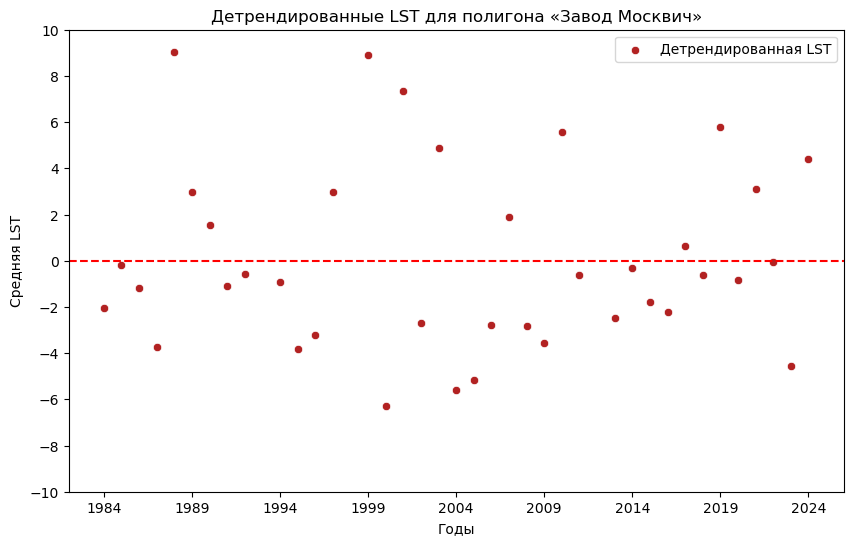

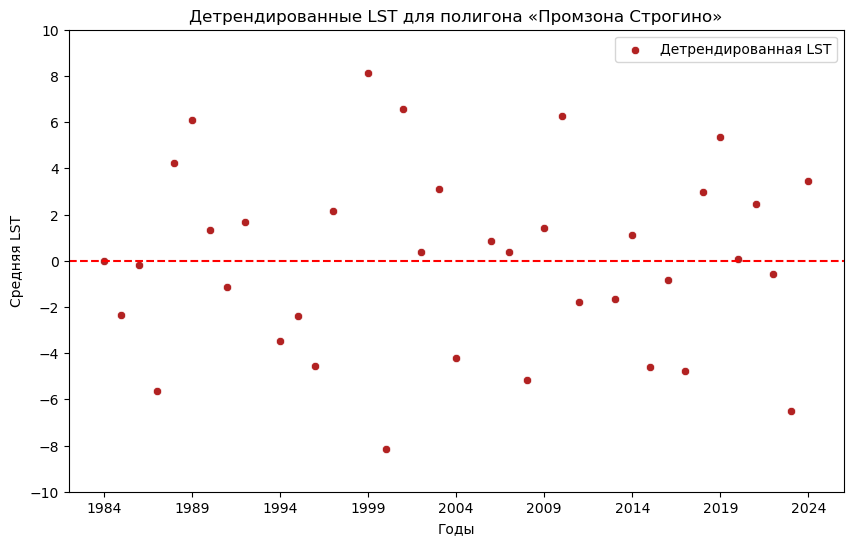

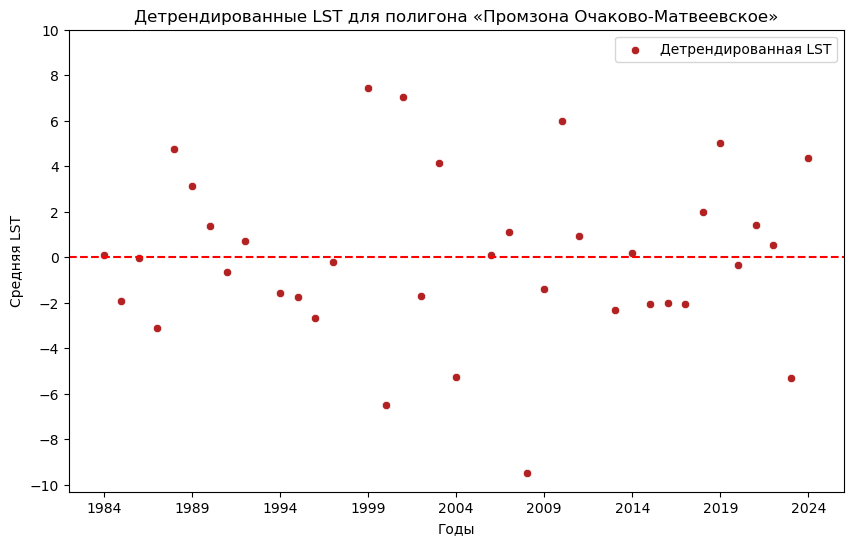

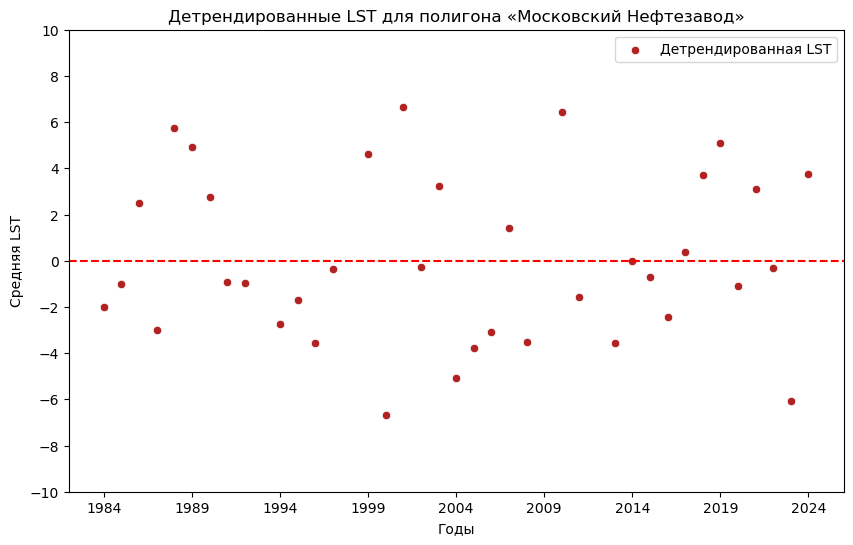

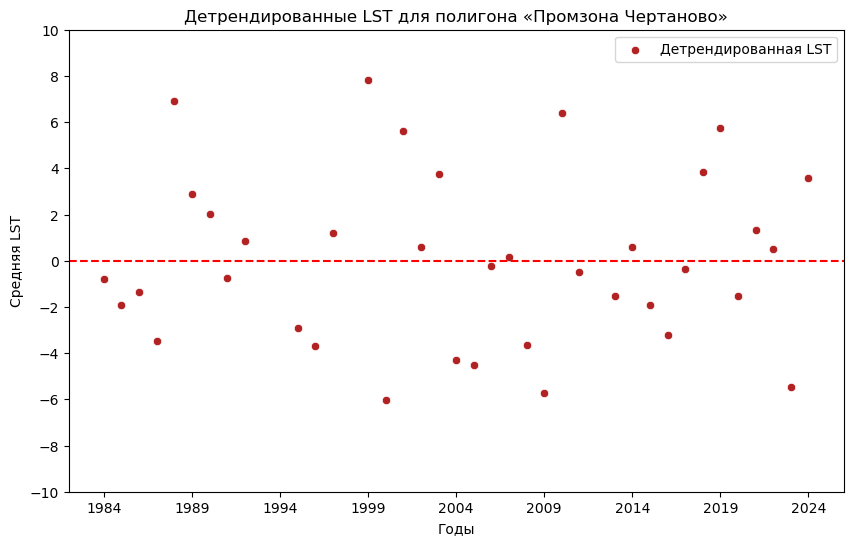

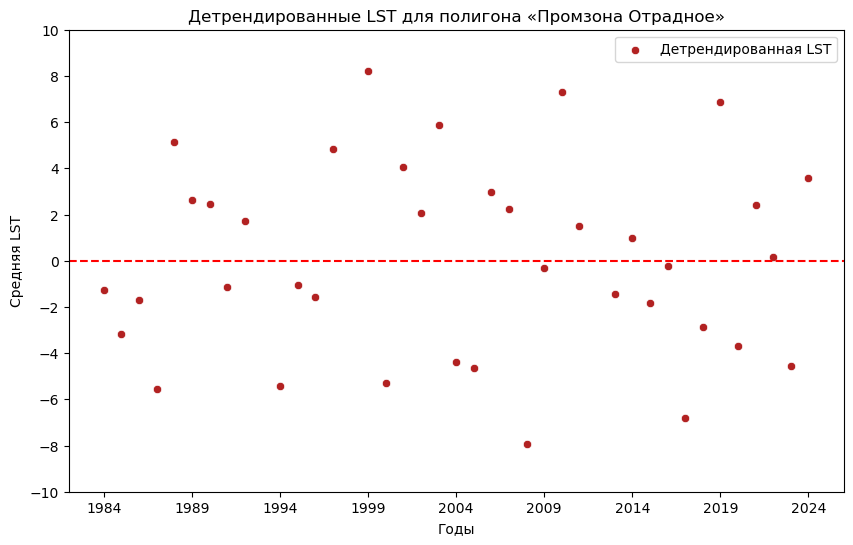

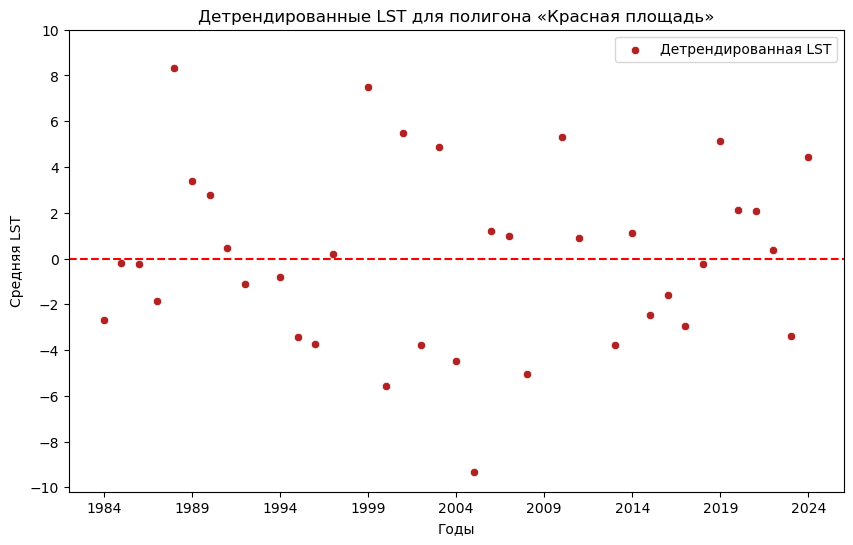

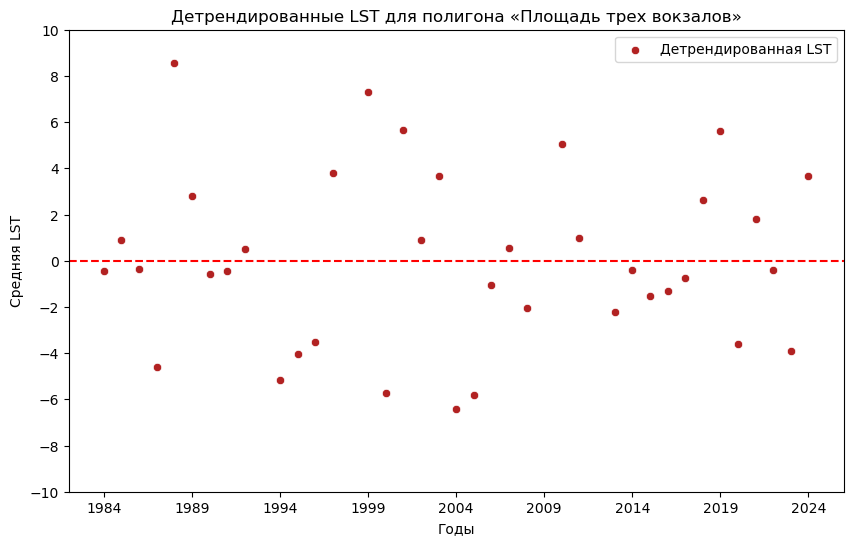

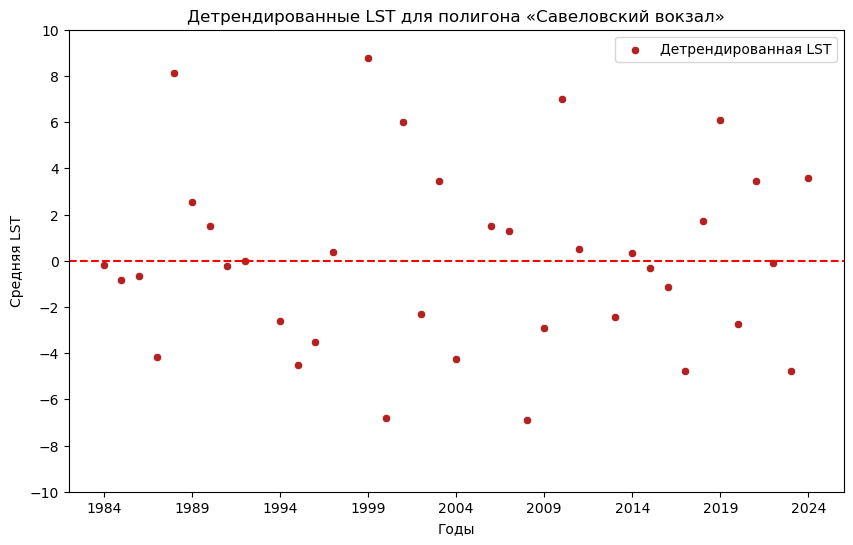

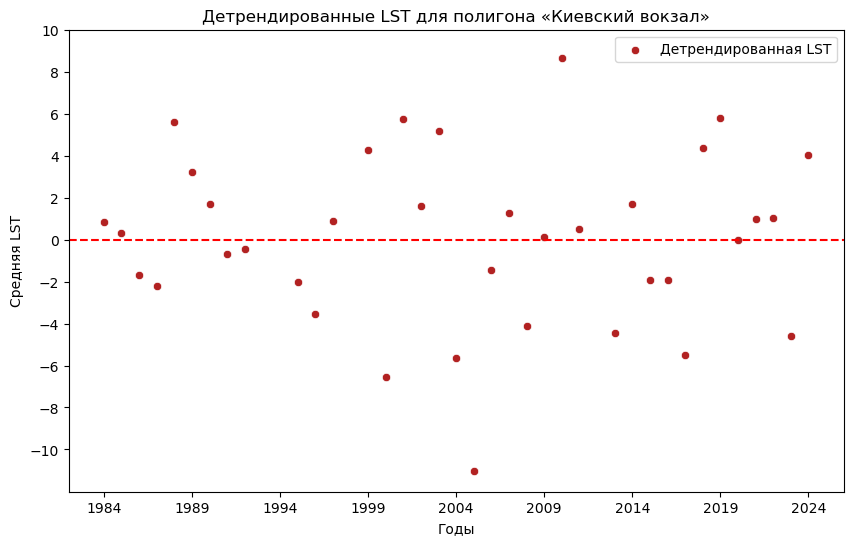

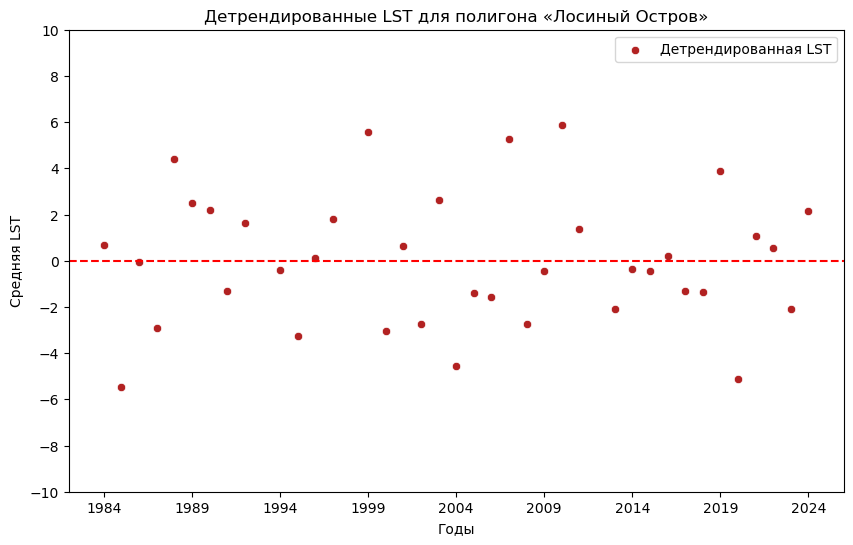

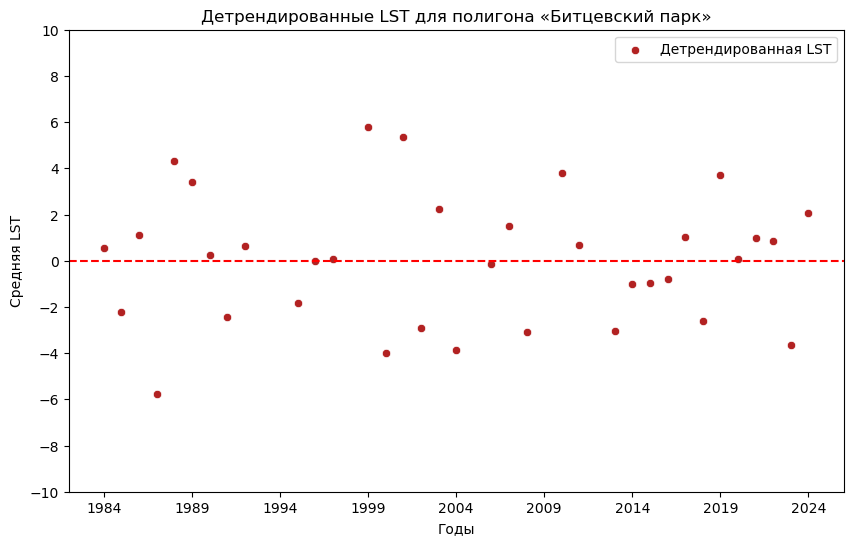

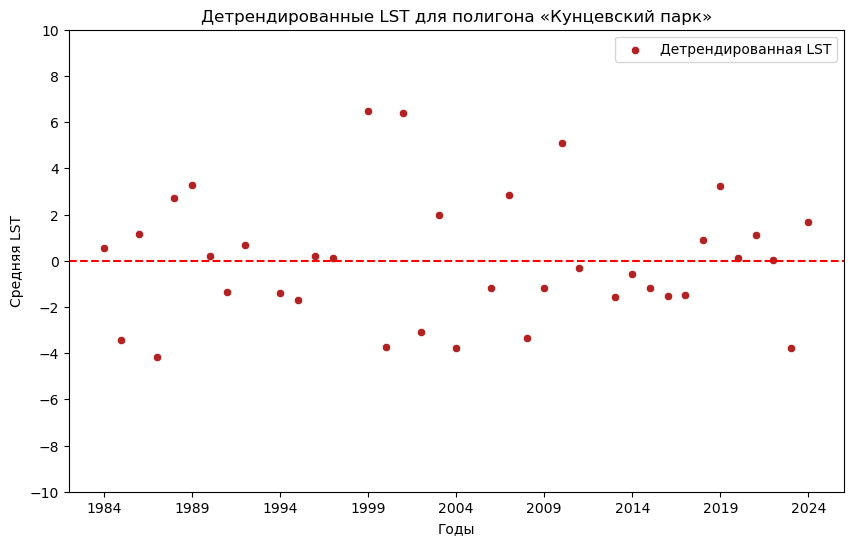

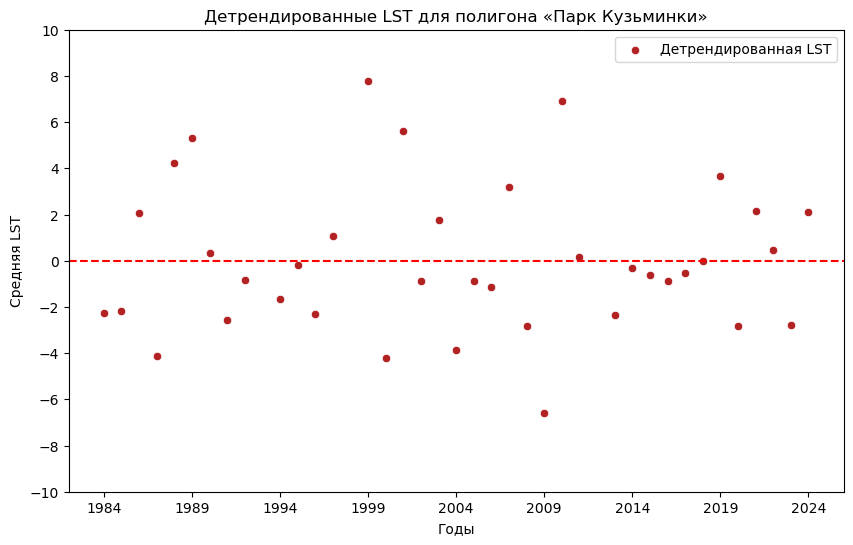

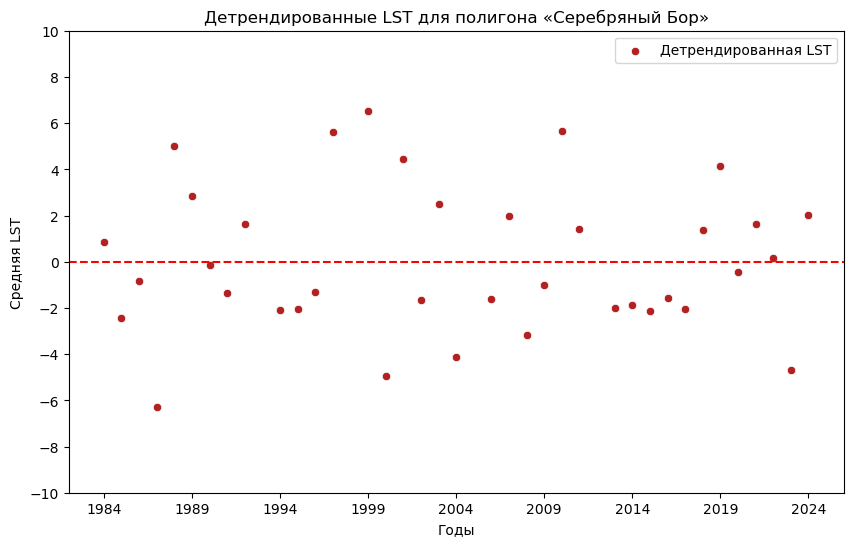

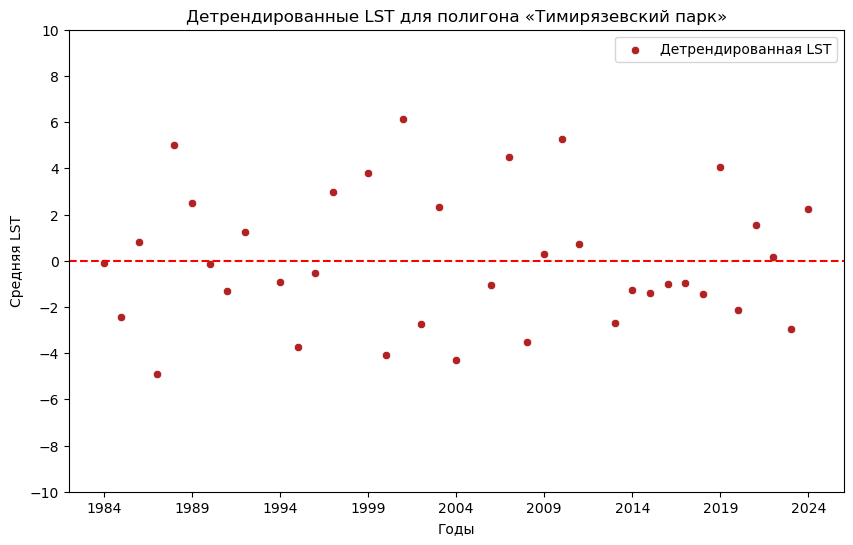

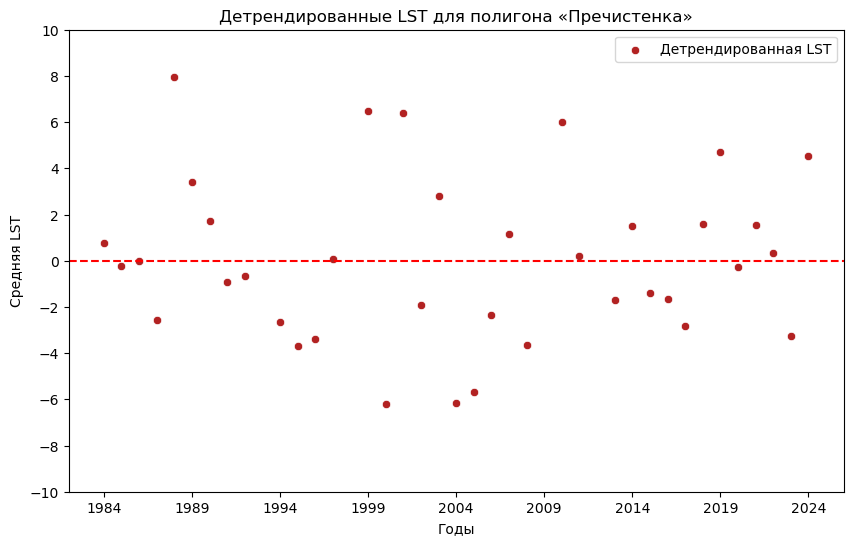

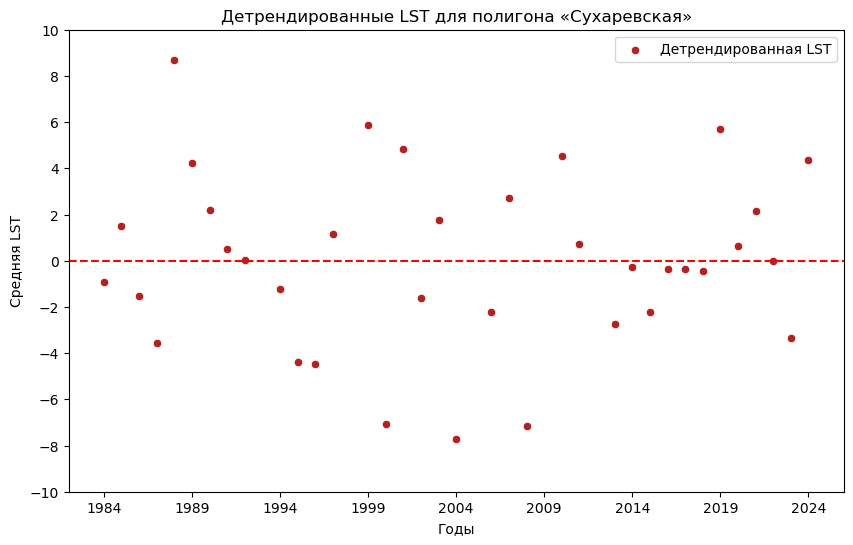

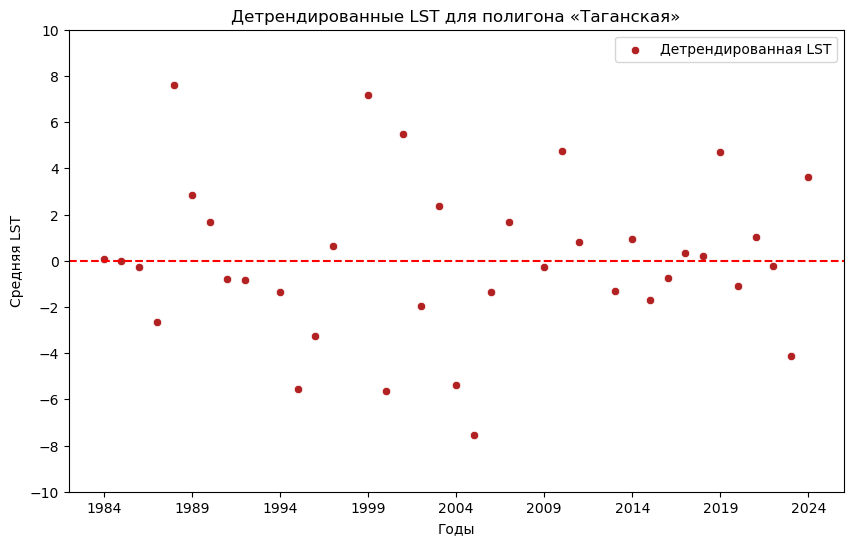

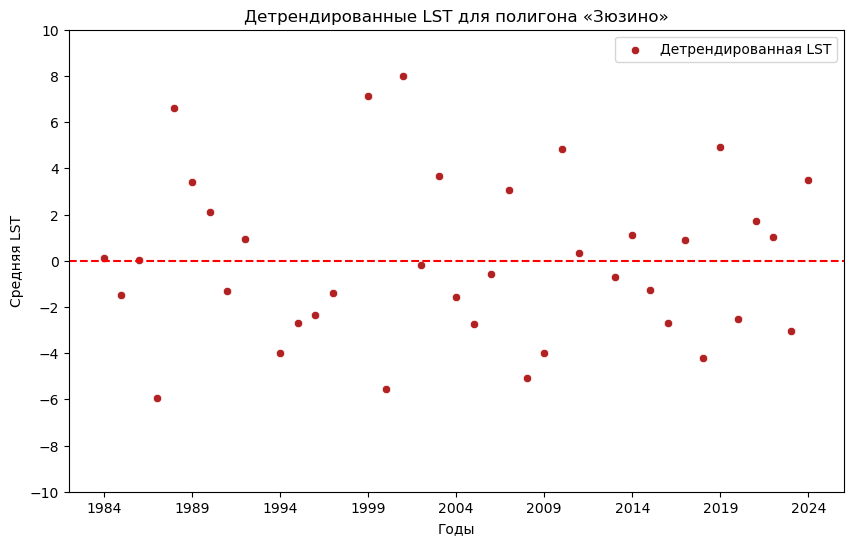

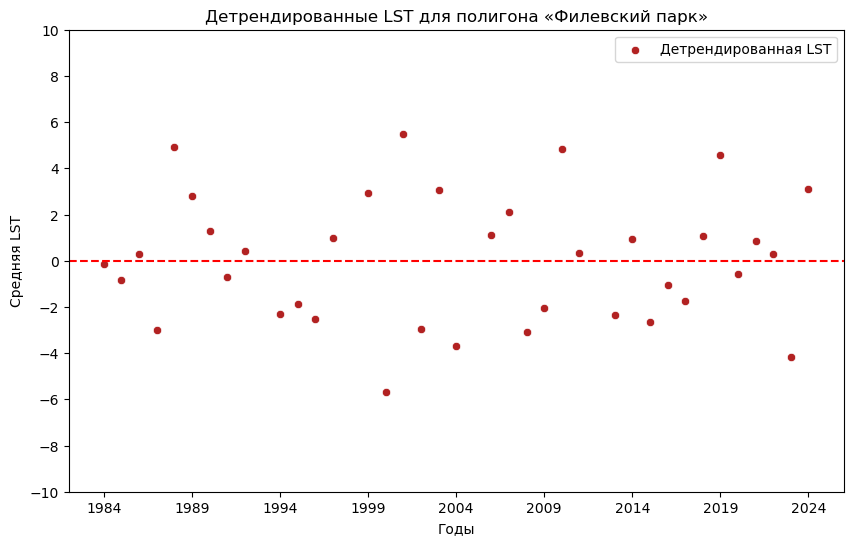

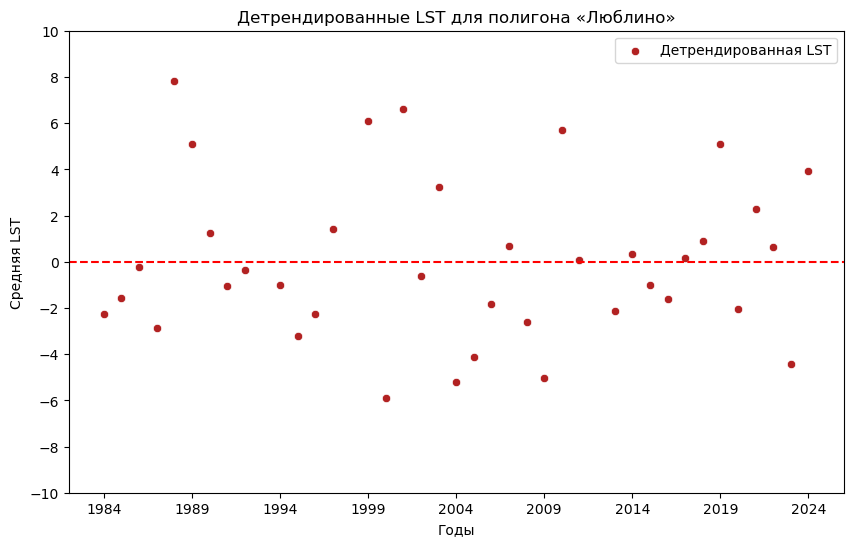

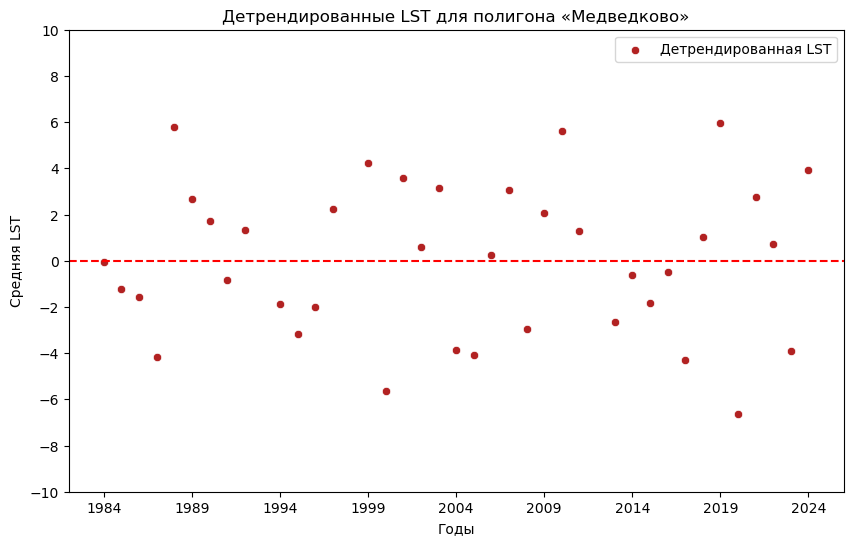

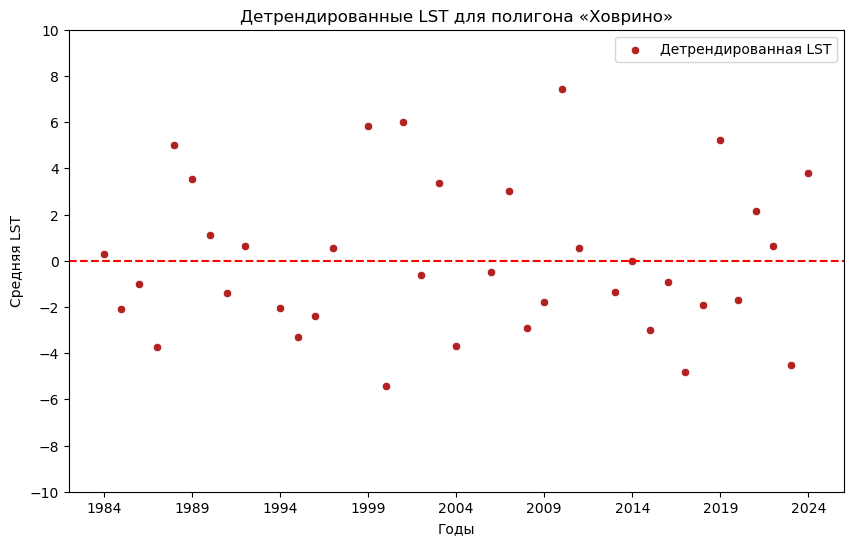

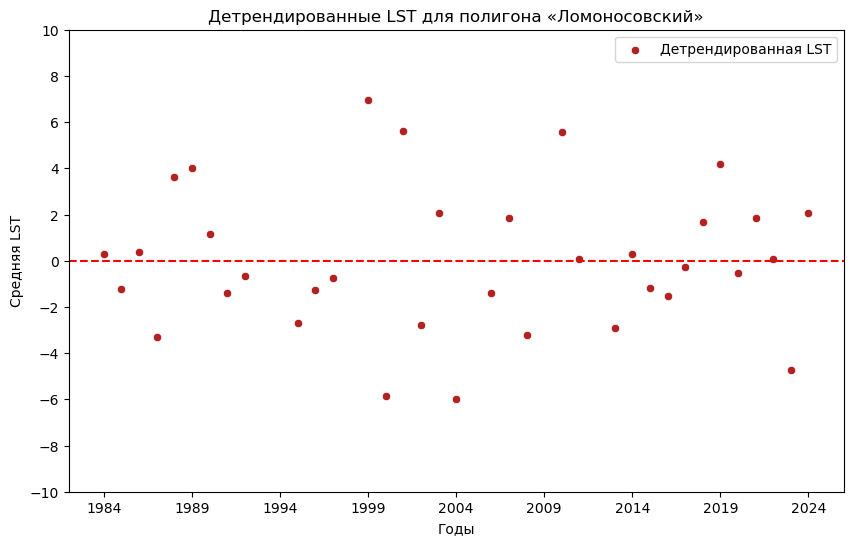

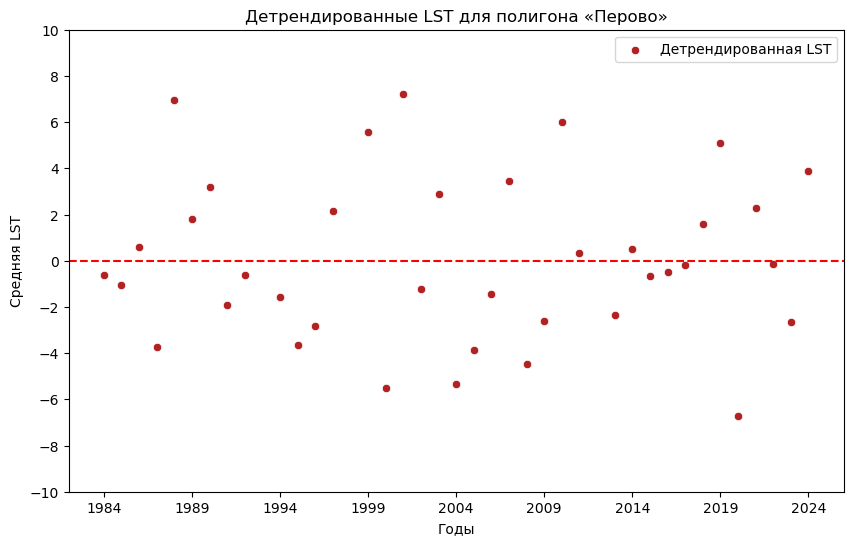

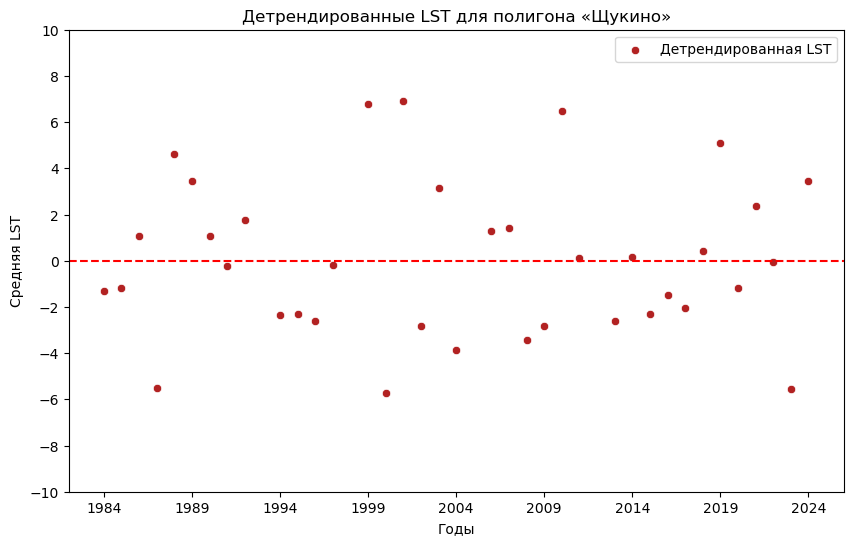

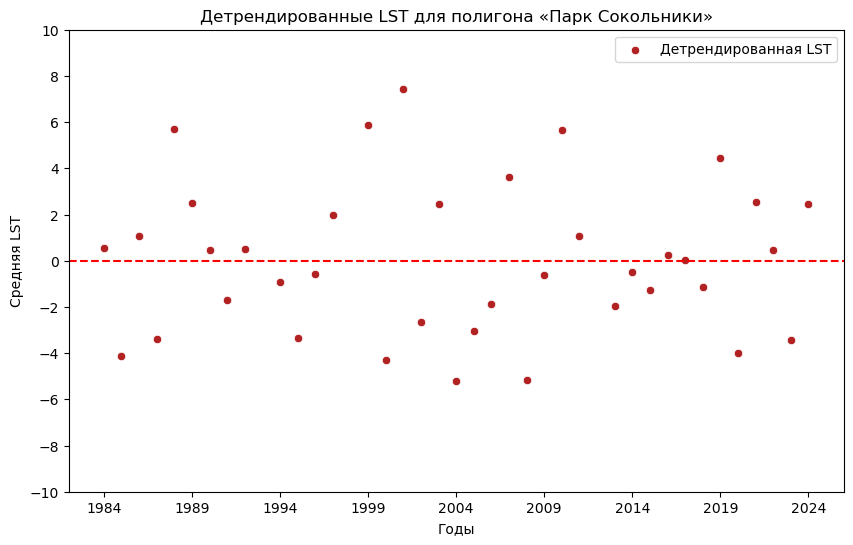

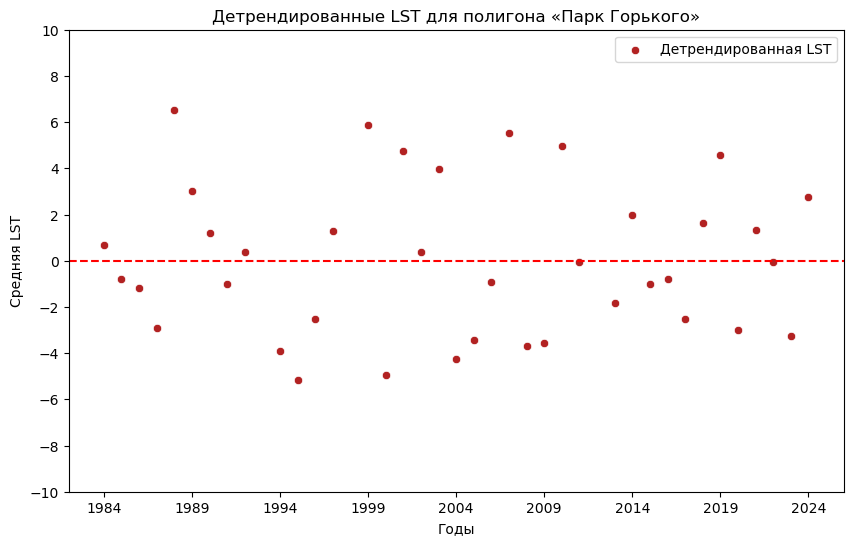

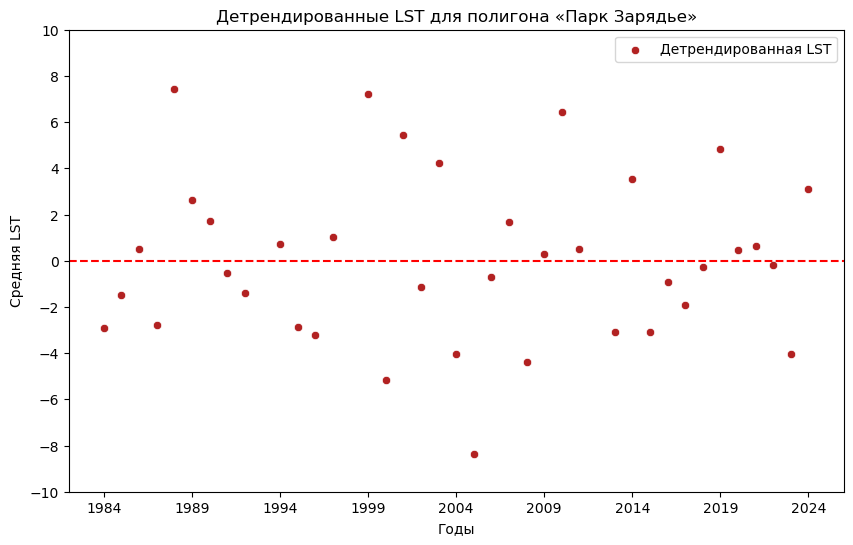

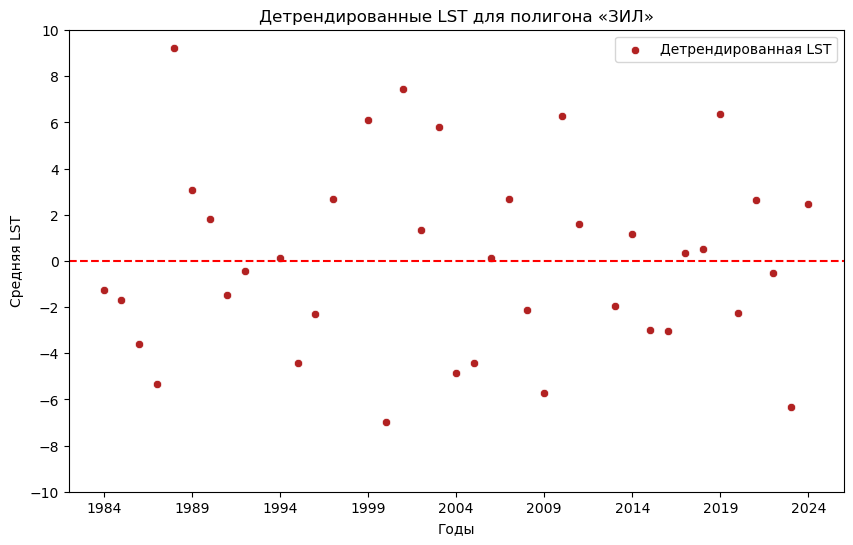

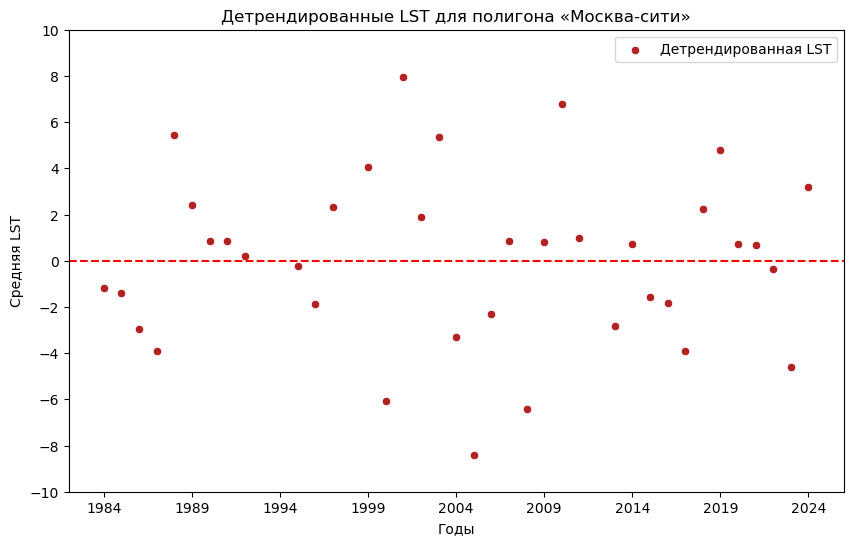

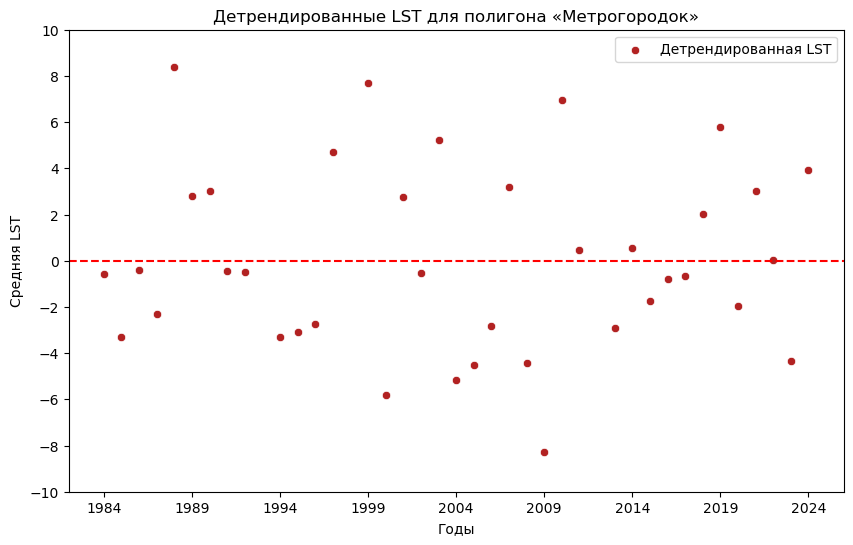

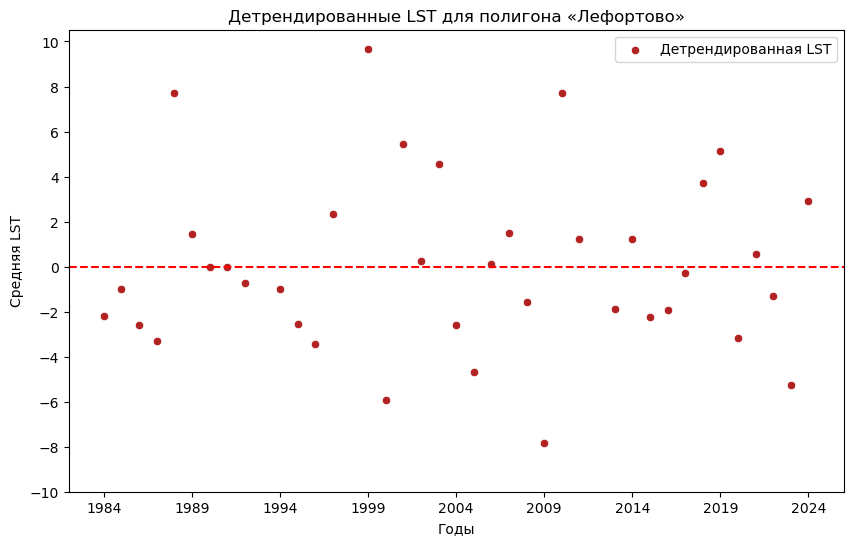

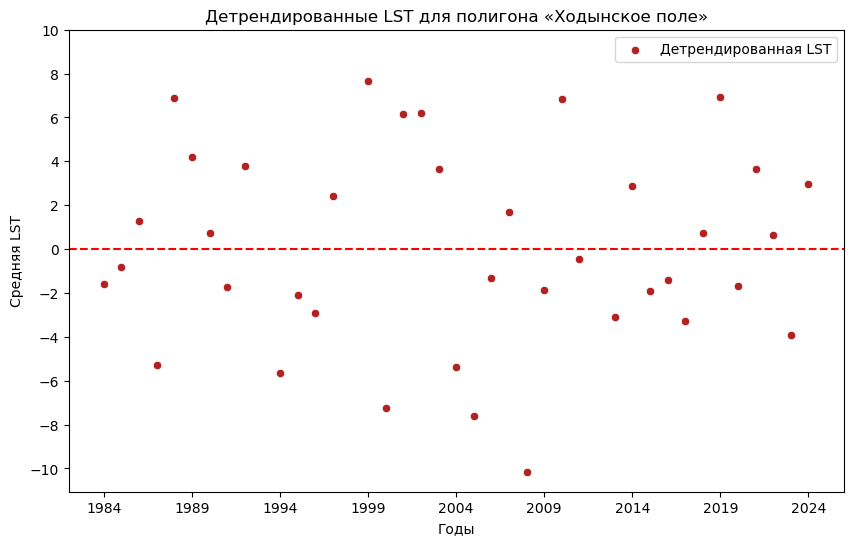

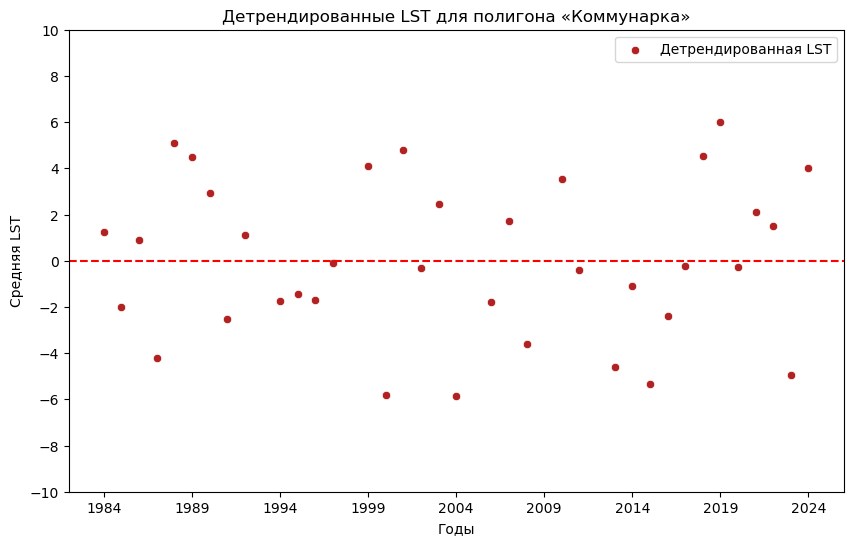

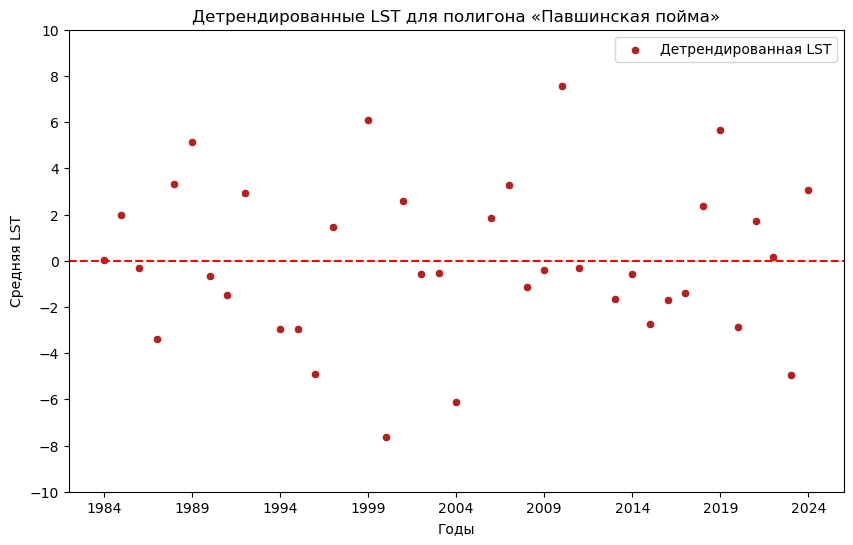

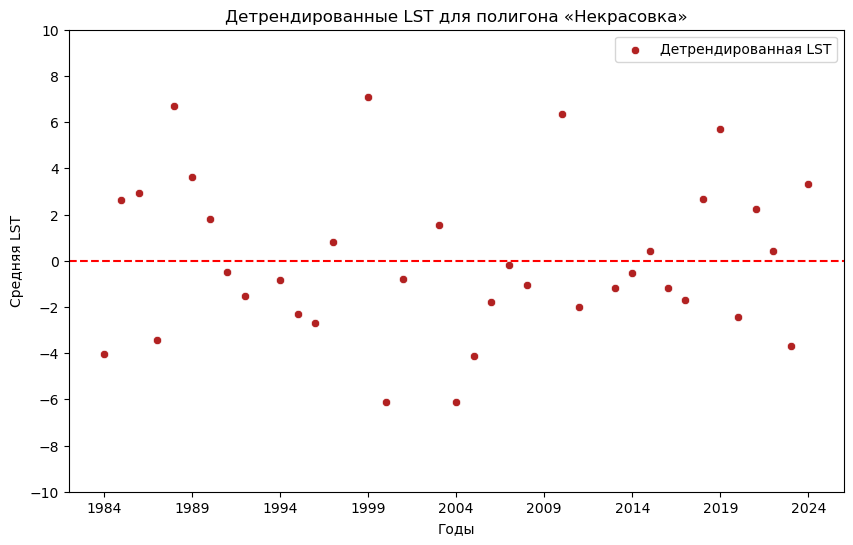

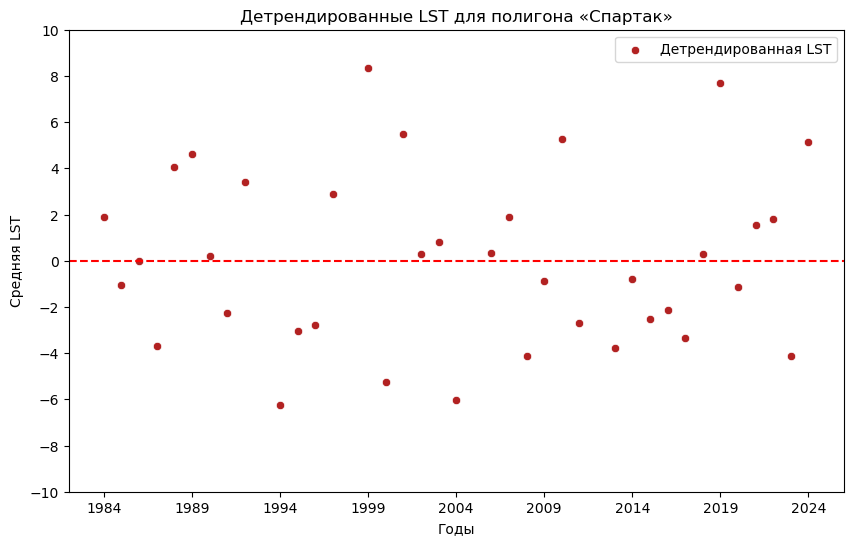

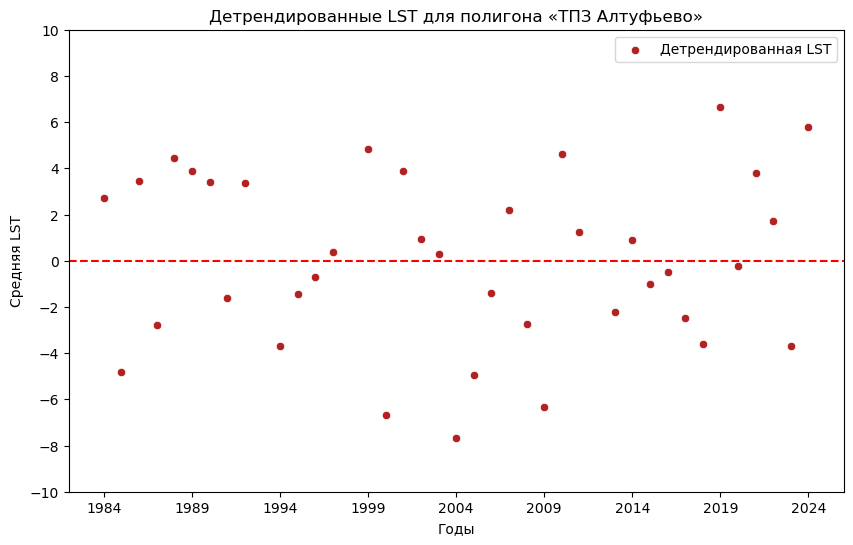

In [58]:
# Цикл для каждого полигона
for ID in polygons_id:

    ts_poly_df_clean = df_clean.loc[ID]
    
    # Получаем данные по году и LST для полигона
    x = ts_poly_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)
    y = ts_poly_df_clean['mean_LST']
    
    lcz_name = ts_poly_df_clean['rus_name'].iloc[0]

    # Детрендируем временной ряд (убираем линейный тренд)
    y_detrended = signal.detrend(y, type='linear')  # Убираем линейный тренд

    # Визуализируем исходные данные и детрендированные данные
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y_detrended, color='firebrick', label='Detrended Data')
    
    plt.axhline(0, color='red', ls='--')

    plt.xlabel('Годы')
    plt.ylabel('Средняя LST')
    title = plt.title(f'Детрендированные LST для полигона «{lcz_name}»')
    plt.legend(['Детрендированная LST'])
    plt.xticks(years_ticks)
    plt.yticks(np.arange(-10,11, 2))
    
    # Сохранение графиков
    # plt.savefig(f'D:\Kursach_2\comps\plots\detrended\{title}.png', bbox_inches='tight')
    plt.show()


# Просмотр тренда по классам

In [59]:
df_clean = df.dropna(subset=['mean_LST'])

In [60]:
classes = df_clean['lcz'].unique()

In [61]:
classes

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [62]:
df_clean = df_clean.reset_index()
df_clean = df_clean.sort_values('lcz')
df_clean = df_clean.set_index('lcz')

In [63]:
df_clean

index  lcz_id            lcz_name   mean_BU   mean_LST  mean_NDBI  \
lcz                                                                      
1        0      11            moscvich -0.273184  28.987634  -0.094475   
1      145      14         neft_moscow -0.174326  36.866835  -0.024517   
1      146      14         neft_moscow -0.164091  38.390080   0.009166   
1      147      14         neft_moscow -0.222231  32.338871  -0.073896   
1      148      14         neft_moscow -0.134864  36.655693   0.011754   
..     ...     ...                 ...       ...        ...        ...   
8     1371      83  pavshinskaya_poyma -0.711548  21.933764  -0.254613   
8     1372      83  pavshinskaya_poyma -0.795980  28.848171  -0.280431   
8     1373      83  pavshinskaya_poyma -0.581324  30.926988  -0.161283   
8     1361      82          kommunarka -0.602723  33.494963  -0.176106   
8     1519      86             severny -0.338018  41.006480  -0.091853   

                  rus_name  year                   classname  
lcz                                                           
1            Завод Москвич  1984                    Промзоны  
1    Московский Нефтезавод  2018                    Промзоны  
1    Московский Нефтезавод  2019                    Промзоны  
1    Московский Нефтезавод  2020                    Промзоны  
1    Московский Нефтезавод  2021                    Промзоны  
..                     ...   ...                         ...  
8         Павшинская пойма  1987  Территории новой застройки  
8         Павшинская пойма  1988  Территории новой застройки  
8         Павшинская пойма  1989  Территории новой застройки  
8               Коммунарка  2018  Территории новой застройки  
8            ТПЗ Алтуфьево  2024  Территории новой застройки  

[1489 rows x 9 columns]

Строим аналогичные графики временных трендов по классам полигонов

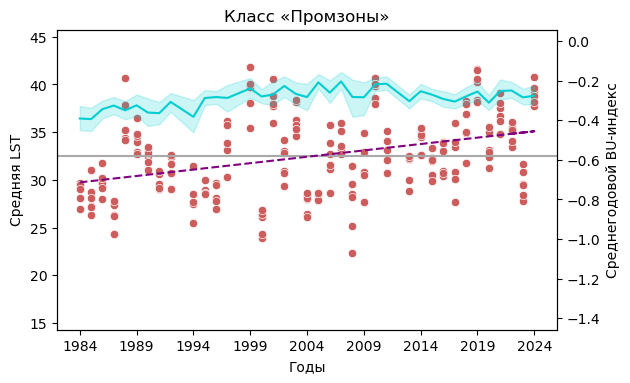

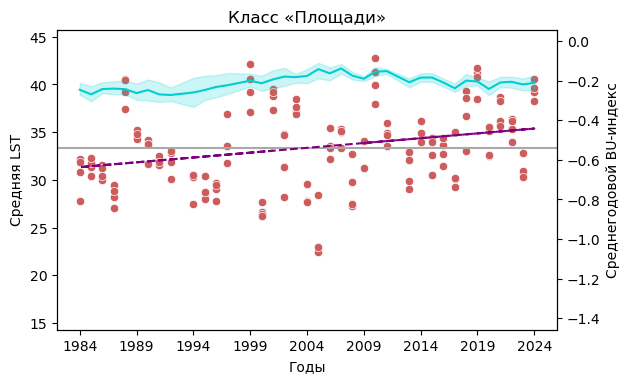

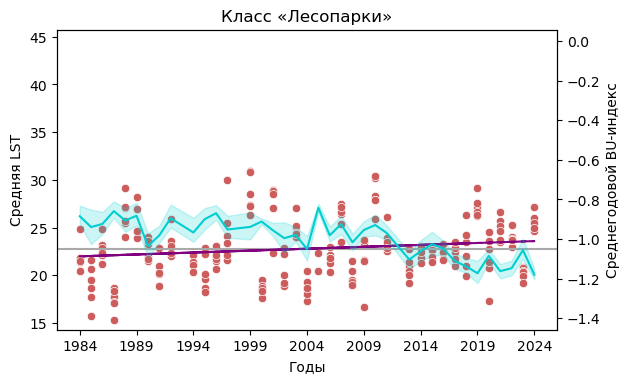

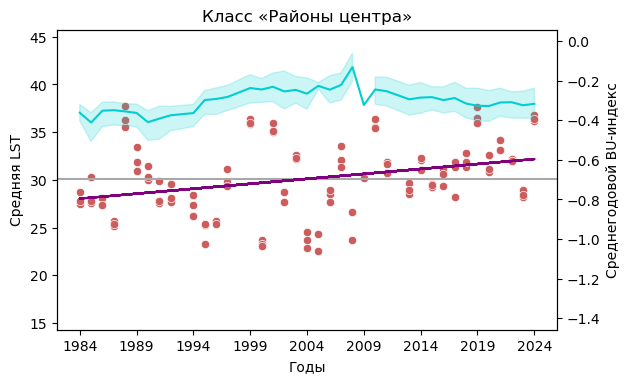

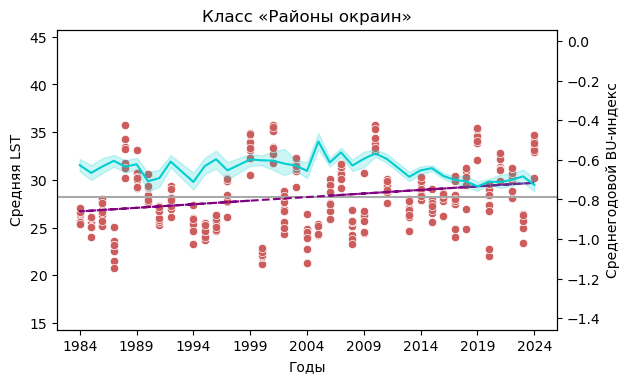

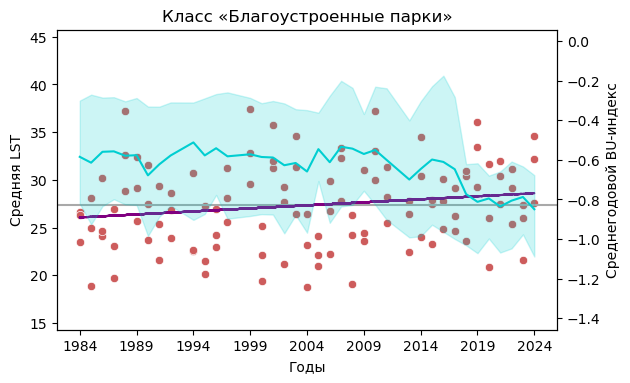

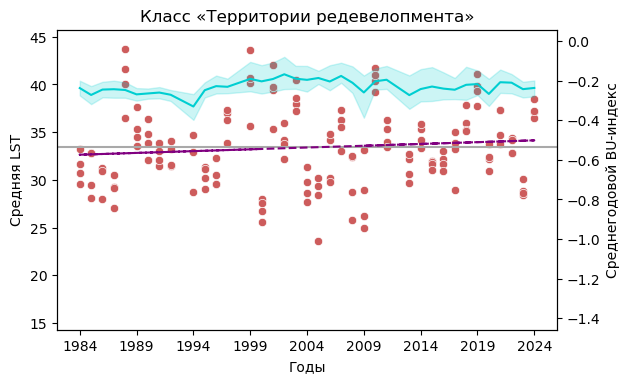

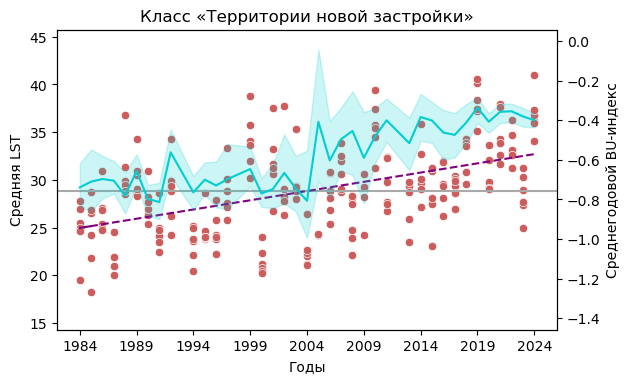

In [64]:
for class_num in classes:
    
    ts_class_df_clean = df_clean.loc[class_num]
    
    x = ts_class_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)
    
    y = ts_class_df_clean['mean_LST']
    ymin = df_clean['mean_LST'].min() - 1
    ymax = df_clean['mean_LST'].max() + 2
    
    y2 = ts_class_df_clean['mean_BU']
    y2min = df_clean['mean_BU'].min() - 0.2
    y2max = df_clean['mean_BU'].max() + 0.1 
    
    fig = plt.figure(figsize=(5,3))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_ylim(ymin, ymax)
    sns.scatterplot(x=x, y=y, ax=ax1, color='indianred')
    ax1.axhline(y.mean(), color='darkgrey')
    #plt.axhline(ts_poly_df_clean['mean_LST'].median(), color='purple')
    
    # Строим линию тренда
    coeffs = np.polyfit(x, y, 1)
    polynomial = np.poly1d(coeffs)
    ax1.plot(x, polynomial(x), color='purple', ls='--')
    ax1.set_xlabel('Годы')
    ax1.set_ylabel('Средняя LST')
    ax1.set_xticks(years_ticks)
    
    ax2 = ax1.twinx()
    ax2.set_ylim(y2min,y2max)
    ax2.set_ylabel('Среднегодовой BU-индекс')
    sns.lineplot(x=x, y=y2, ax=ax2, color='darkturquoise')

    title = plt.title("Класс «"+ts_class_df_clean['classname'].iloc[0]+'»')
    # plt.savefig(f'D:\Kursach_2\comps\plots\{title}.png', bbox_inches='tight')
    
    plt.show()

Статистическая проверка по классам

In [65]:
df_clean

index  lcz_id            lcz_name   mean_BU   mean_LST  mean_NDBI  \
lcz                                                                      
1        0      11            moscvich -0.273184  28.987634  -0.094475   
1      145      14         neft_moscow -0.174326  36.866835  -0.024517   
1      146      14         neft_moscow -0.164091  38.390080   0.009166   
1      147      14         neft_moscow -0.222231  32.338871  -0.073896   
1      148      14         neft_moscow -0.134864  36.655693   0.011754   
..     ...     ...                 ...       ...        ...        ...   
8     1371      83  pavshinskaya_poyma -0.711548  21.933764  -0.254613   
8     1372      83  pavshinskaya_poyma -0.795980  28.848171  -0.280431   
8     1373      83  pavshinskaya_poyma -0.581324  30.926988  -0.161283   
8     1361      82          kommunarka -0.602723  33.494963  -0.176106   
8     1519      86             severny -0.338018  41.006480  -0.091853   

                  rus_name  year                   classname  
lcz                                                           
1            Завод Москвич  1984                    Промзоны  
1    Московский Нефтезавод  2018                    Промзоны  
1    Московский Нефтезавод  2019                    Промзоны  
1    Московский Нефтезавод  2020                    Промзоны  
1    Московский Нефтезавод  2021                    Промзоны  
..                     ...   ...                         ...  
8         Павшинская пойма  1987  Территории новой застройки  
8         Павшинская пойма  1988  Территории новой застройки  
8         Павшинская пойма  1989  Территории новой застройки  
8               Коммунарка  2018  Территории новой застройки  
8            ТПЗ Алтуфьево  2024  Территории новой застройки  

[1489 rows x 9 columns]

In [66]:
results_class = [] 

for class_num in classes:
    # Фильтруем по классу
    ts_class_df_clean = df_clean.loc[class_num]

    x = ts_class_df_clean['year'].values
    y = ts_class_df_clean['mean_LST'].values
    
    # Линейная регрессия
    slope, intercept, r_value, p_value, std_err = st.linregress(x, y)
    
    # Сохраняем результат
    results_class.append({
        'lcz_class': class_num,
        'classname': ts_class_df_clean['classname'].iloc[0],
        'n_points': len(ts_class_df_clean),
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'p_value': p_value,
        'std_err': std_err
    })

# Превращаем в DataFrame
results_class_df = pd.DataFrame(results_class)

In [67]:
results_class_df.sort_values('lcz_class')

# Статистика тренда температур по классам

lcz_class                   classname  n_points     slope   intercept  \
0          1                    Промзоны       224  0.133947 -236.019176   
1          2                     Площади       148  0.101118 -169.290489   
2          3                   Лесопарки       222  0.040040  -57.463339   
3          4               Районы центра       110  0.103641 -177.594671   
4          5               Районы окраин       298  0.074936 -121.982970   
5          6       Благоустроенные парки       114  0.063456  -99.843392   
6          7   Территории редевелопмента       151  0.037593  -41.954161   
7          8  Территории новой застройки       222  0.193433 -358.816650   

    r_value       p_value   std_err  
0  0.386917  2.053487e-09  0.021425  
1  0.297494  2.406831e-04  0.026857  
2  0.157751  1.867735e-02  0.016898  
3  0.336920  3.193103e-04  0.027869  
4  0.264420  3.691335e-06  0.015886  
5  0.176713  5.999730e-02  0.033397  
6  0.113037  1.669980e-01  0.027071  
7  0.505657  8.201009e-16  0.022251

In [68]:
results_class_df[results_class_df['p_value']<0.05]

# Значимые классы

lcz_class                   classname  n_points     slope   intercept  \
0          1                    Промзоны       224  0.133947 -236.019176   
1          2                     Площади       148  0.101118 -169.290489   
2          3                   Лесопарки       222  0.040040  -57.463339   
3          4               Районы центра       110  0.103641 -177.594671   
4          5               Районы окраин       298  0.074936 -121.982970   
7          8  Территории новой застройки       222  0.193433 -358.816650   

    r_value       p_value   std_err  
0  0.386917  2.053487e-09  0.021425  
1  0.297494  2.406831e-04  0.026857  
2  0.157751  1.867735e-02  0.016898  
3  0.336920  3.193103e-04  0.027869  
4  0.264420  3.691335e-06  0.015886  
7  0.505657  8.201009e-16  0.022251

In [69]:
results_class_df[results_class_df['p_value']>0.05]

# Незначимые классы

lcz_class                  classname  n_points     slope  intercept  \
5          6      Благоустроенные парки       114  0.063456 -99.843392   
6          7  Территории редевелопмента       151  0.037593 -41.954161   

    r_value   p_value   std_err  
5  0.176713  0.059997  0.033397  
6  0.113037  0.166998  0.027071

Детрендирование классов через scipy.detrend

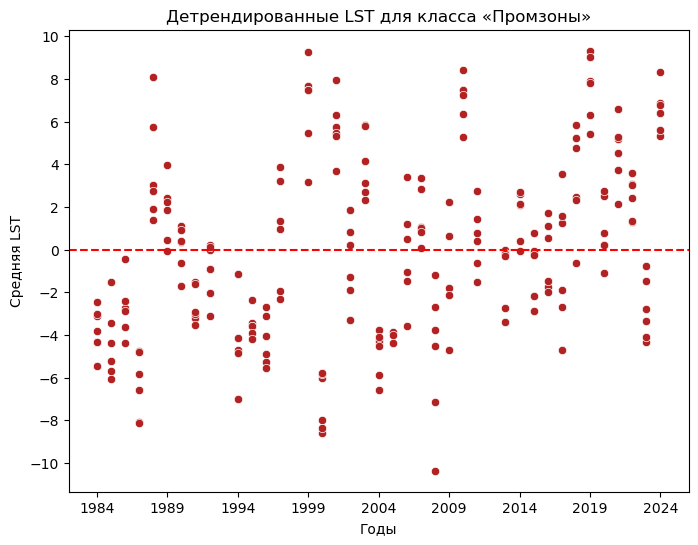

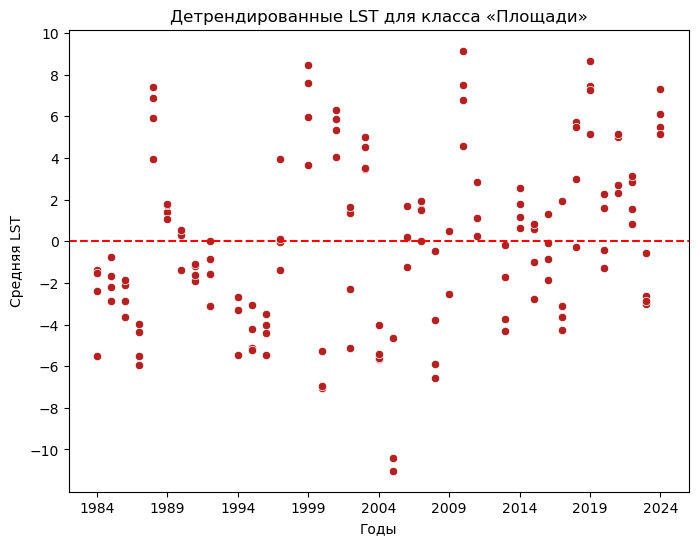

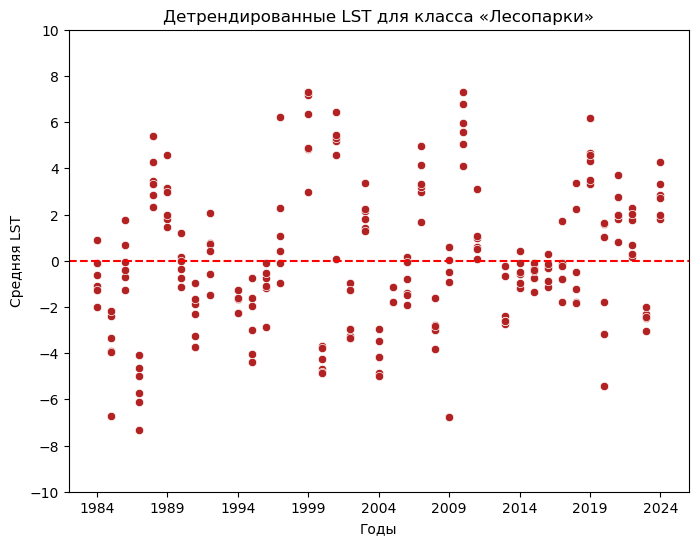

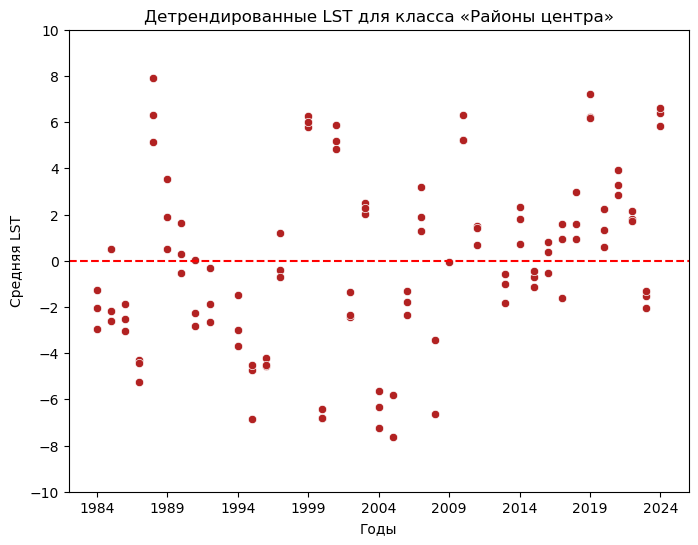

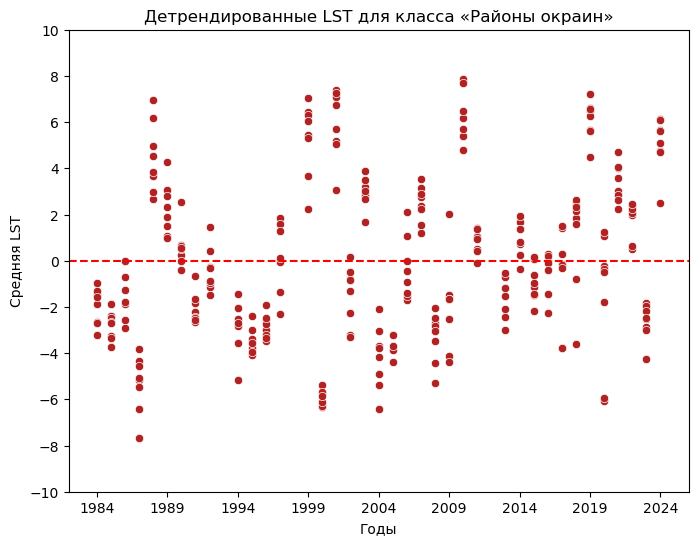

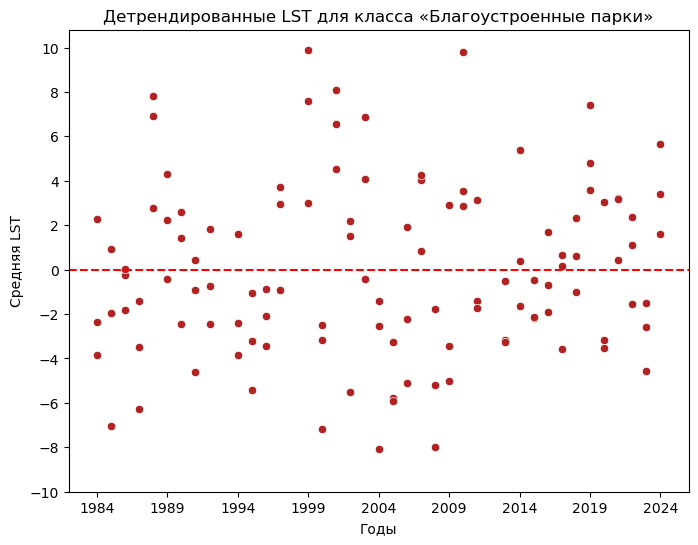

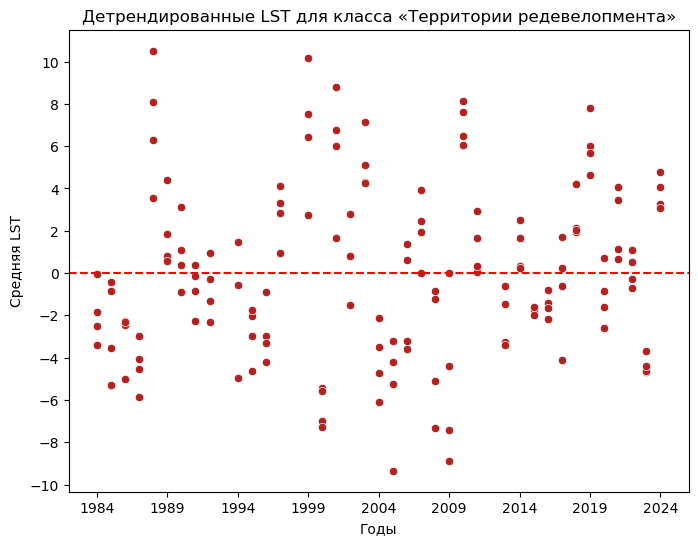

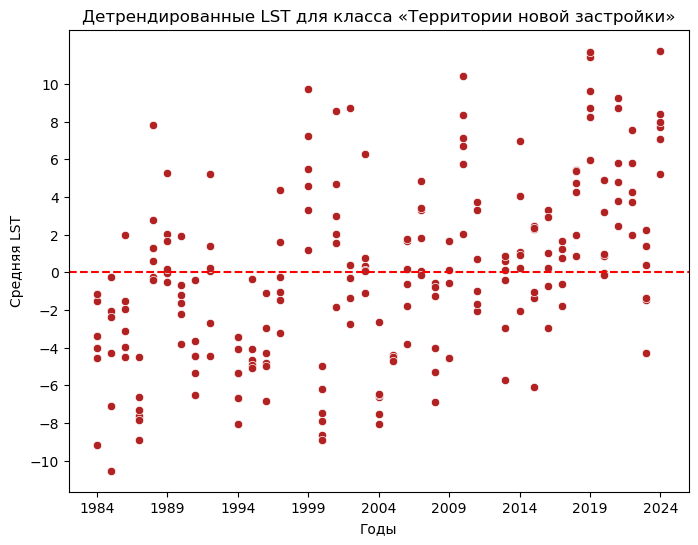

In [70]:
# Цикл для каждого класса
for class_num in classes:

    ts_class_df_clean = df_clean.loc[class_num]
    
    # Получаем данные по году и LST для полигона
    x = ts_class_df_clean['year']
    years_ticks = np.arange(x.min(), x.max()+1, 5)
    y = ts_class_df_clean['mean_LST']
    
    lcz_class = ts_class_df_clean['classname'].iloc[0]

    # Детрендируем временной ряд (убираем линейный тренд)
    y_detrended = signal.detrend(y, type='linear')  # Убираем линейный тренд

    # Визуализируем исходные данные и детрендированные данные
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    #fig = plt.figure(figsize=(5,3))
    sns.scatterplot(x=x, y=y_detrended, color='firebrick', label='Detrended Data')
    
    plt.axhline(0, color='red', ls='--')

    plt.xlabel('Годы')
    plt.ylabel('Средняя LST')
    title = plt.title(f'Детрендированные LST для класса «{lcz_class}»')
    plt.xticks(years_ticks)
    plt.yticks(np.arange(-10,11, 2))
    ax.get_legend().remove()
    
    # Сохранение графиков
    # plt.savefig(f'D:\Kursach_2\comps\plots\detrended\{title}.png', bbox_inches='tight')
    plt.show()


# Общий просмотр по классам

In [71]:
results_df[results_df['class'] == 1]

class  lcz_id                      lcz_name  n_points     slope  \
0      1      11                 Завод Москвич        38  0.130765   
1      1      12             Промзона Строгино        37  0.162024   
2      1      13  Промзона Очаково-Матвеевское        37  0.118237   
3      1      14         Московский Нефтезавод        37  0.122761   
4      1      15            Промзона Чертаново        37  0.115194   
5      1      16             Промзона Отрадное        38  0.152717   

    intercept   r_value   p_value   std_err  
0 -228.365502  0.375792  0.020067  0.053744  
1 -291.936446  0.451539  0.005028  0.054117  
2 -205.631368  0.370808  0.023862  0.050055  
3 -214.558833  0.390669  0.016818  0.048894  
4 -198.080149  0.358904  0.029150  0.050638  
5 -273.592570  0.411191  0.010328  0.056425

In [72]:
results_df[results_df['class'] == 2]

class  lcz_id               lcz_name  n_points     slope   intercept  \
6      2      21        Красная площадь        37  0.080689 -129.584444   
7      2      22  Площадь трех вокзалов        37  0.137777 -242.051247   
8      2      23     Савеловский вокзал        37  0.085237 -137.018483   
9      2      24        Киевский вокзал        37  0.100271 -167.510994   

    r_value   p_value   std_err  
6  0.247991  0.138894  0.053280  
7  0.413057  0.011057  0.051347  
8  0.257951  0.123215  0.053964  
9  0.288416  0.083424  0.056268

In [73]:
results_df[results_df['class'] == 3]

class  lcz_id            lcz_name  n_points     slope   intercept  \
10      3      31      Лосиный Остров        38  0.032433  -43.166169   
11      3      32     Битцевский парк        35  0.048910  -76.148225   
12      3      33     Кунцевский парк        37  0.067380 -112.641972   
13      3      34      Парк Кузьминки        38  0.021938  -20.775689   
14      3      35      Серебряный Бор        37  0.027254  -30.077454   
15      3      36  Тимирязевский парк        37  0.043503  -64.366062   

     r_value   p_value   std_err  
10  0.137782  0.409418  0.038858  
11  0.214964  0.214933  0.038682  
12  0.292617  0.078828  0.037218  
13  0.083301  0.619037  0.043740  
14  0.106362  0.530953  0.043067  
15  0.182548  0.279517  0.039605

In [74]:
results_df[results_df['class'] == 4]

class  lcz_id     lcz_name  n_points     slope   intercept   r_value  \
16      4      41  Пречистенка        37  0.096228 -162.979797  0.317494   
17      4      42  Сухаревская        36  0.090310 -150.456509  0.287365   
18      4      43    Таганская        37  0.124449 -219.465923  0.411370   

     p_value   std_err  
16  0.055514  0.048580  
17  0.089245  0.051624  
18  0.011423  0.046609

In [75]:
results_df[results_df['class'] == 5]

class  lcz_id        lcz_name  n_points     slope   intercept   r_value  \
19      5      51          Зюзино        38  0.075756 -123.792897  0.253782   
20      5      52  Филевский парк        37  0.119509 -211.298563  0.471593   
21      5      53         Люблино        38  0.077787 -126.706461  0.264365   
22      5      54      Медведково        38  0.060555  -92.967750  0.219560   
23      5      55         Ховрино        37  0.083722 -140.043156  0.299292   
24      5      56   Ломоносовский        35  0.042830  -58.614915  0.171288   
25      5      57          Перово        38  0.045228  -62.581134  0.154391   
26      5      58          Щукино        37  0.094206 -160.137307  0.326271   

     p_value   std_err  
19  0.124183  0.048123  
20  0.003214  0.037773  
21  0.108737  0.047295  
22  0.185346  0.044845  
23  0.071933  0.045116  
24  0.325190  0.042885  
25  0.354703  0.048239  
26  0.048745  0.046134

In [76]:
results_df[results_df['class'] == 6]

class  lcz_id         lcz_name  n_points     slope   intercept   r_value  \
27      6      61  Парк Сокольники        38  0.051869  -79.968758  0.191476   
28      6      62    Парк Горького        38  0.092662 -158.190727  0.327939   
29      6      63     Парк Зарядье        38  0.045837  -61.370692  0.155045   

     p_value   std_err  
27  0.249485  0.044313  
28  0.044433  0.044489  
29  0.352645  0.048677

In [77]:
results_df[results_df['class'] == 7]

class  lcz_id      lcz_name  n_points     slope   intercept   r_value  \
30      7      71           ЗИЛ        38  0.005899   22.794451  0.017772   
31      7      72   Москва-сити        37  0.060716  -89.676013  0.198041   
32      7      73  Метрогородок        38  0.077804 -123.037941  0.232669   
33      7      74     Лефортово        38  0.008949   16.056685  0.028412   

     p_value   std_err  
30  0.915660  0.055312  
31  0.240007  0.050796  
32  0.159803  0.054203  
33  0.865538  0.052475

In [78]:
results_df[results_df['class'] == 8]

class  lcz_id          lcz_name  n_points     slope   intercept   r_value  \
34      8      81    Ходынское поле        38  0.120236 -209.134265  0.312526   
35      8      82        Коммунарка        36  0.152229 -278.204923  0.489584   
36      8      83  Павшинская пойма        37  0.200457 -373.007838  0.588290   
37      8      84        Некрасовка        36  0.222683 -418.071050  0.637175   
38      8      85           Спартак        37  0.158696 -289.729726  0.463757   
39      8      86     ТПЗ Алтуфьево        38  0.303915 -580.134609  0.705110   

         p_value   std_err  
34  5.608874e-02  0.060908  
35  2.441112e-03  0.046497  
36  1.284860e-04  0.046575  
37  2.930977e-05  0.046194  
38  3.840138e-03  0.051246  
39  7.709641e-07  0.050939